# Prédiction émissions de CO2

Nous devons prédire les émissions de CO2, hors nous n'avons pour cette étude que des quantités de gaz à effet de serre,<br>
sachant que ceux-ci sont composés de CO2 à environ 80%, nous simplifierons donc en considérant que les émissions de gaz<br>
à effet de serre sont équivalentes aux émissions de CO2.


In [1]:
# installation des modules necessaires
#!pip install shap graphviz


## chargement des bibliothèques

In [2]:
#import des modules necessaires
import os
import time
import datetime as dt
import requests
import shutil
import math

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn import set_config
set_config(print_changed_only=False)


## Définition des fonctions

In [3]:
# Création du dossier export
def CreationDir(dossierExport):
    if not os.path.exists(dossierExport):
        os.makedirs(dossierExport)

In [4]:
def delFeature(df,Feat2del=0):
    """Efface les features qui n'ont qu'une seule valeur"""
    if Feat2del == 0 :
        tmp = df.nunique()
        cols=tmp[tmp==1].index
        df.drop(columns=cols, inplace=True)
        colonnes = [col for col in cols]
        print('Liste des colonnes inutiles supprimées :',colonnes)
    else:
        for feat in Feat2del:
            if (feat in df.columns):
                df.drop(columns=feat, inplace=True)
            else:
                print('colonne',feat,'inexistante !')
        print('Liste des colonnes supprimées :',Feat2del)


In [5]:
def delIndividus(Datas,Indexes):
    """
    # Purge d'individus 
    # Liste des paramètres :
    #  - Data       : nom du dataframe a modifier
    #  - Indexes    : indexes a purger [liste des indexes]
    """
    print('------------------ Purge des individus ------------------')
    if len(Indexes) > 0:
            #récupération du nom du dataframe
            nomData = [name for name in globals() if globals()[name] is Datas]
            nomDf = ''.join(nomData)
            print('\n-- suppression de ',len(Indexes),' indexes du DataFrame ',nomDf)
            Datas.drop(Indexes, inplace=True)
    else:
            print('aucun index a supprimer !')

In [6]:
def graphResult(X,reel,pred,X_name=""):
    dfMod = pd.DataFrame()
    dfMod['X']=X
    dfMod['Reel']=reel
    dfMod['Pred']=pred
    titre=str(Cible[0])+""
    ylabel=str(Cible[0])+" "+str(Cible[2])

    dfMod=dfMod.sort_values(by=['X'])
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(121)
    plt.scatter(dfMod['X'], dfMod['Reel'], s=5, color="blue", label="réel")
    plt.plot(dfMod['X'], dfMod['Pred'], lw=1.5, color="red", label="prédiction")
    plt.title(titre, fontsize=14, pad=25)
    plt.ylabel(ylabel, fontsize=10)
    if X_name != "":
        plt.xlabel(X_name, fontsize=10)
    plt.legend()
    ax2 = fig.add_subplot(122)
    plt.scatter( dfMod['Reel'], dfMod['Pred'], s=5, color="blue", label="réel")
    plt.title("Confrontation prédictions", fontsize=14, pad=25)
    plt.ylabel('Valeurs prédites', fontsize=10)
    plt.xlabel('Valeurs réelles', fontsize=10)
    plt.show()

In [7]:
def scores(model,X_train,X_test,y_train,y_test,y_pred):
    print(f"X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
    print(f"X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")
    print("")
    print(f"Score train:{round(model.score(X_train,y_train),5)}")
    print(f"Score test:{round(model.score(X_test,y_test),5)}")
    print(f"R2  :{round(r2_score(y_test, y_pred),5)}")
    print(f"Mse :{round(mean_squared_error(y_test, y_pred),5)}")
    print(f"Rmse:{round(math.sqrt(mean_squared_error(y_test, y_pred)),5)}")


In [59]:
def ImportanceFeaturesMDI(model,Affnum=0):
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    feature_names=preprocessor.fit_transform(X_train).columns
    changeChars=[('pipeline-1__',''),('pipeline-2__','')]
    for rech, trgt in changeChars:
        feature_names = [name.replace(rech,trgt) for name in feature_names]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances.sort_values(ascending=False, inplace=True)
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111)

    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Importance des Features avec MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

    if Affnum != 0:
        print('Visualisation de l\importance des variables sous forme numérique :')
        print(forest_importances.sort_values(ascending=False))
        print('')

## Chargement des données

In [9]:
Id_Random=66
dossierData='Datas'
dossierExport=dossierData+'/'
fichierimport=dossierData+'/Data_cleared.csv'

In [10]:
# Chargement des données
dfDataInput_filtered = pd.read_csv(fichierimport, sep='|', lineterminator='\n', encoding='utf-8')

## Choix de la cible

In [11]:
Cible=['Emissions totales de CO2','TotalGHGEmissions','(T CO2)']

## Vérification des données

In [12]:
dfDataInput_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   OSEBuildingID          1446 non-null   int64  
 1   BuildingType           1446 non-null   object 
 2   PrimaryPropertyType    1446 non-null   object 
 3   ZipCode                1443 non-null   float64
 4   CouncilDistrictCode    1446 non-null   int64  
 5   Neighborhood           1446 non-null   object 
 6   Latitude               1446 non-null   float64
 7   Longitude              1446 non-null   float64
 8   NumberofBuildings      1446 non-null   float64
 9   NumberofFloors         1446 non-null   int64  
 10  PropertyGFATotal       1446 non-null   int64  
 11  ENERGYSTARScore        929 non-null    float64
 12  SiteEUI(kBtu/sf)       1446 non-null   float64
 13  SourceEUI(kBtu/sf)     1446 non-null   float64
 14  SiteEnergyUse(kBtu)    1446 non-null   float64
 15  Stea

In [13]:
mylist = list(dfDataInput_filtered.select_dtypes(include=['object']).columns)
print(mylist)
for feat in mylist:
    print('=========================',feat,'=========================')
    print(dfDataInput_filtered[feat].value_counts())

['BuildingType', 'PrimaryPropertyType', 'Neighborhood']
========================= BuildingType =========================
BuildingType
NonResidential        1349
Nonresidential COS      69
Campus                  17
SPS-District K-12       10
Nonresidential WA        1
Name: count, dtype: int64
========================= PrimaryPropertyType =========================
PrimaryPropertyType
Small- and Mid-Sized Office    281
Other                          222
Warehouse                      183
Large Office                   157
Mixed Use Property             106
Retail Store                    84
Hotel                           69
Worship Facility                68
Distribution Center             52
K-12 School                     50
Supermarket / Grocery Store     38
Medical Office                  35
Self-Storage Facility           28
University                      21
Senior Care Community           19
Refrigerated Warehouse          12
Restaurant                      11
Laboratory        

Nous pouvons voir la présence de quartiers en doublons à cause de la casse 

In [14]:
# modification de la casse des noms de quartiers
dfDataInput_filtered['Neighborhood']=dfDataInput_filtered['Neighborhood'].str.upper()
dfDataInput_filtered['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN                 319
GREATER DUWAMISH         318
LAKE UNION               139
MAGNOLIA / QUEEN ANNE    139
EAST                     105
NORTHEAST                 94
NORTHWEST                 76
BALLARD                   59
NORTH                     58
CENTRAL                   43
DELRIDGE                  39
SOUTHEAST                 29
SOUTHWEST                 28
Name: count, dtype: int64

In [15]:
# modification de l'unique valeur 'BuildingType' 'Nonresidential WA' en 'Nonresidential'
dfDataInput_filtered.loc[dfDataInput_filtered['BuildingType']=='Nonresidential WA','BuildingType']='NonResidential'
dfDataInput_filtered['BuildingType'].value_counts()

BuildingType
NonResidential        1350
Nonresidential COS      69
Campus                  17
SPS-District K-12       10
Name: count, dtype: int64

In [16]:
dfDataInput_filtered.shape

(1446, 30)

## Selection des données

In [17]:
y = dfDataInput_filtered[Cible[1]]
X = dfDataInput_filtered.drop(Cible[1], axis=1)

## Premier modèle BaseLine (LinearRegression)

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.23423
Score test:0.25477
R2  :0.25477
Mse :21788.41917
Rmse:147.60901


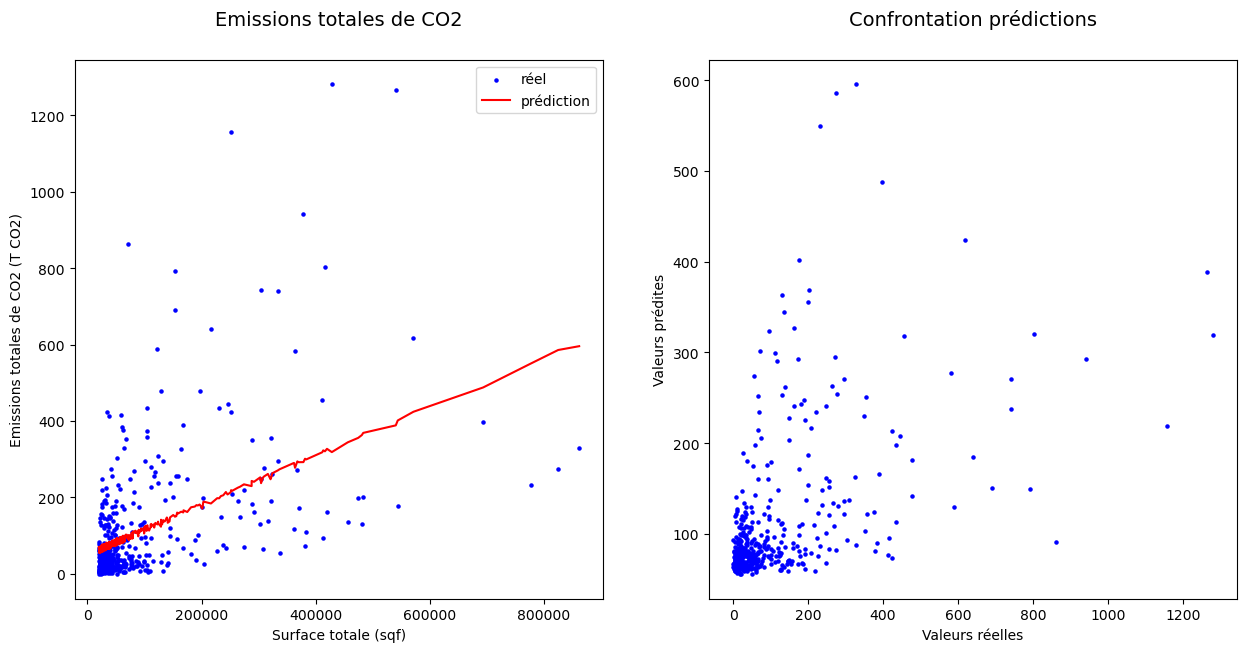

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random)

features=['PropertyGFATotal','AgeBuilding']
pipe_features=make_pipeline(SimpleImputer())
preprocessor=make_column_transformer((pipe_features, features))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')


## Amélioration du feature engineering

### Modèle avec normalisation (StandardScaler)

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.23423
Score test:0.25477
R2  :0.25477
Mse :21788.41917
Rmse:147.60901


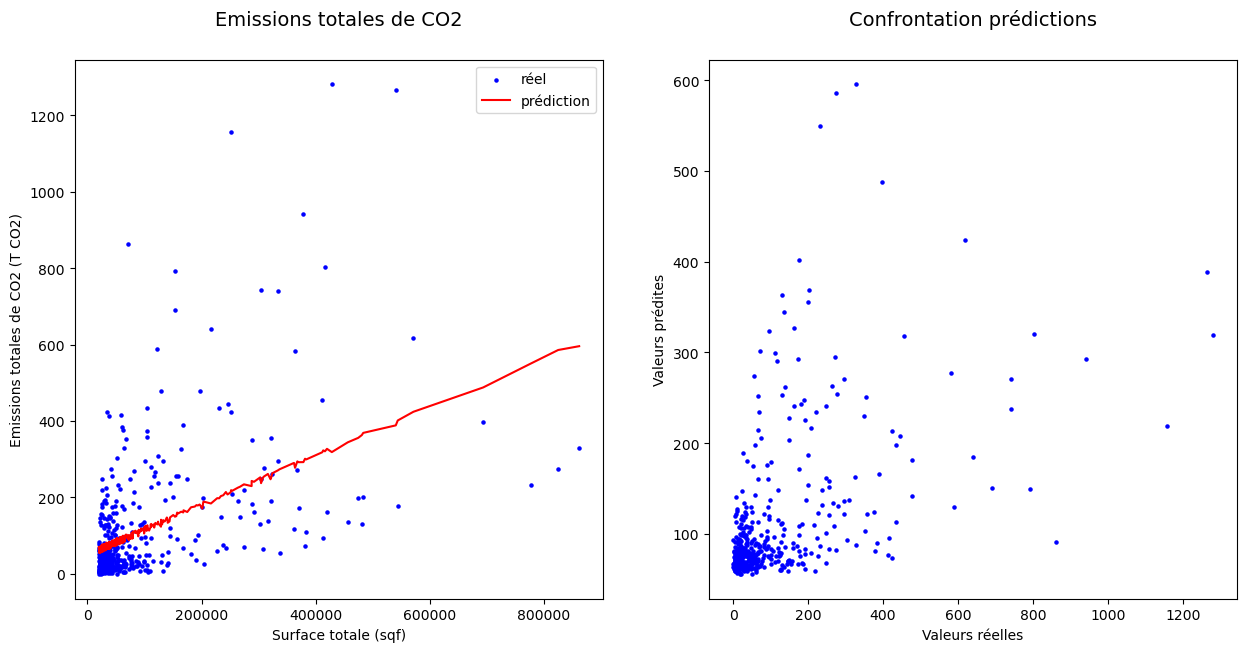

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random)

features=['PropertyGFATotal','AgeBuilding']
pipe_features=make_pipeline(SimpleImputer(), StandardScaler())
preprocessor=make_column_transformer((pipe_features, features))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')



### Augmentation du nombre de features

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.44468
Score test:0.35743
R2  :0.35743
Mse :18786.97286
Rmse:137.06558


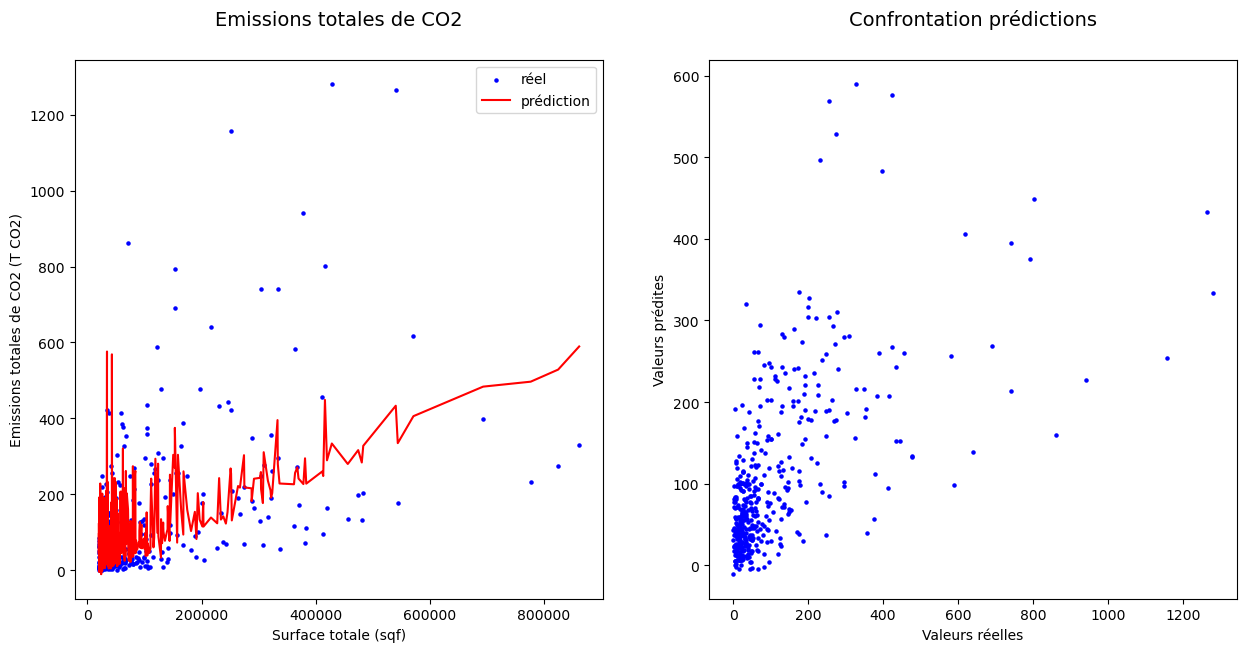

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')

### Ajout du mix énergetique des batiments

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.55867
Score test:0.47098
R2  :0.47098
Mse :15466.91054
Rmse:124.36603


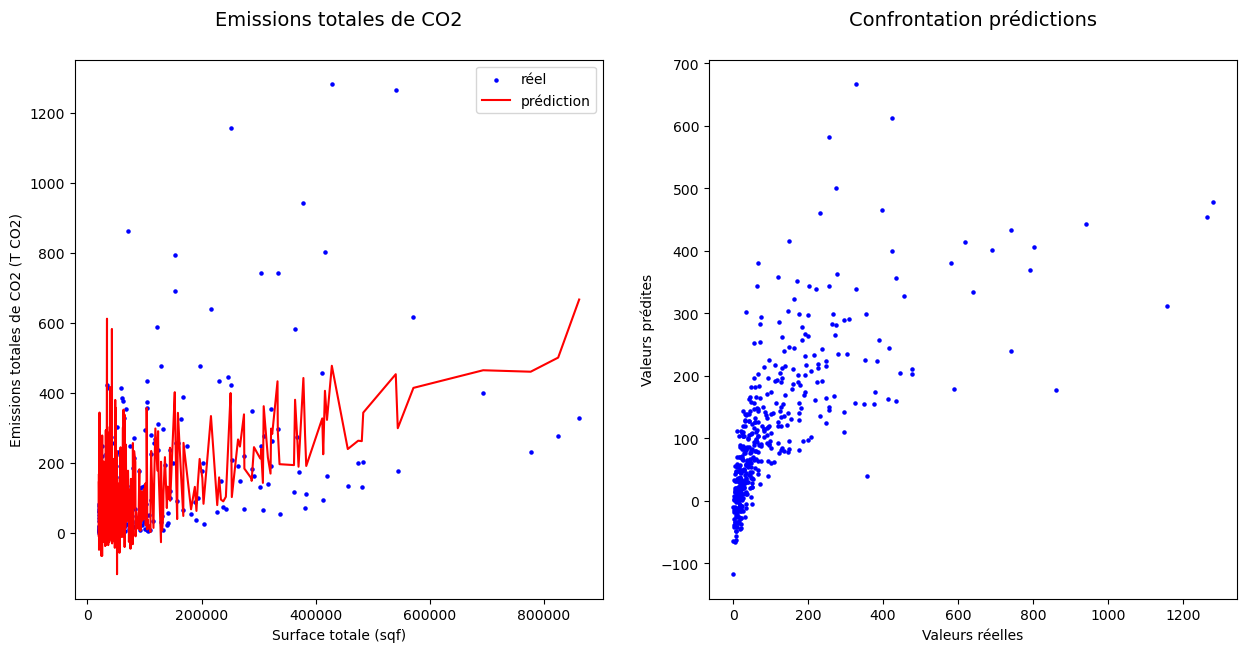

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles))

model=make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')

## Simulation d'autres modèles et choix du modèle final

### Industrialisation de la recherche de solution

In [22]:
# définition des modèles testés et de leurs hyperparamètres
Modeles2Test=[[LinearRegression(),{
                  'linearregression__fit_intercept': [True, False],
                  'linearregression__copy_X': [True, False]}],
              [SVR(),{
                  'svr__gamma' : ['auto','scale'],
                  'svr__epsilon' : [0.001, 0.01, 0.1, 1],
                  'svr__C' : [0.001, 0.01, 0.1, 1, 10],
                  'svr__tol':[0.001]}],
              [Lasso(),{
                  'lasso__alpha':[1,0.1,0.01,0.001],
                  'lasso__max_iter':[1000],
                  'lasso__tol':[0.001]}],
              [Ridge(),{
                  'ridge__alpha':[1,0.1,0.01,0.001],
                  'ridge__max_iter':[1000],
                  'ridge__tol':[0.001]}],
              [ElasticNet(),{
                  'elasticnet__alpha': [1,0.1,0.01,0.001],
                  'elasticnet__max_iter': [1000],
                  'elasticnet__tol': [0.001]}],
              [GradientBoostingRegressor(),{
                  'gradientboostingregressor__n_estimators':[100, 500, 1000],
                  'gradientboostingregressor__max_depth': [None]}],
              [RandomForestRegressor(),{
                  'randomforestregressor__n_estimators': [100, 500, 1000],
                  'randomforestregressor__max_features': [None,"log2"],
                  'randomforestregressor__n_jobs': [-1],
                  'randomforestregressor__max_depth': [None]}]]

> définition des modèles testés et des paramètres a ajuster

In [23]:
def scores2(model,X_train,X_test,y_train,y_test,y_pred,temps):
    scoreTrain=round(model.score(X_train,y_train),5)
    scoreTest=round(model.score(X_test,y_test),5)
    mse=round(mean_squared_error(y_test, y_pred),5)
    rmse=round(math.sqrt(mean_squared_error(y_test, y_pred)),5)
    print(f"Temps d\'execution : {temps}s")
    print(f"Score train :{scoreTrain}")
    print(f"Score test  :{scoreTest}")
    print(f"Mse :{mse}")
    print(f"Rmse:{rmse}")
    return [scoreTrain,scoreTest,mse,rmse,temps]


In [24]:
def TestModeles(Donnees,Modeles2Test):
    y = Donnees[Cible[1]]
    X = Donnees.drop(Cible[1], axis=1)
    sortie=[]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) #, stratify=y

    features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                         'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)', 'NrjVap(pct)',
                         'NrjGaz(pct)']
    features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

    pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
    pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
    preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                         (pipe_categoriel, features_categorielles))

    for ModeleAndParams in Modeles2Test:
        Modele2Test=ModeleAndParams[0]
        Params2Test=ModeleAndParams[1]
        ModelName=str(Modele2Test)[:str(Modele2Test).rfind("(")]
        # teste modèle de base
        print(f"Modèle {ModelName} base : ")
        model=make_pipeline(preprocessor, Modele2Test)        # mise en place pipelne
        depart = time.time()                                  # début chrono
        model.fit(X_train, y_train)                           # fit du modèle
        temps = round(time.time() - depart,3)                 # fin chrono
        y_pred=model.predict(X_test)                          # calcul prédictions
        scoreReturnBase=scores2(model,X_train,X_test,y_train,y_test,y_pred,temps)  # calcul du score
        graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)') # graphes

        # test modèle recherche param gridsearch
        print(f"Modèle {ModelName} grid : ")
        model2=make_pipeline(preprocessor, Modele2Test)       # mise en place pipelne
        #print(model2.get_params().keys())
        modelgd=GridSearchCV(model2, param_grid=Params2Test, verbose=0, n_jobs=-1, cv=5, refit=True)  # mise en place pipelne
        depart = time.time()                                  # début chrono
        modelgd.fit(X_train, y_train)                         # fit du modèle
        temps = round(time.time() - depart,3)                 # fin chrono
        print(f"meilleurs paramètres : {modelgd.best_params_}")
        y_pred=modelgd.predict(X_test)                        # calcul prédictions
        scoreReturnGrd=scores2(modelgd,X_train,X_test,y_train,y_test,y_pred,temps)  # calcul du score
        graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)') # graphes

        # test modèle recherche param random
        print(f"Modèle {ModelName} random :")
        model3=make_pipeline(preprocessor, Modele2Test)       # mise en place pipelne
        #print(model2.get_params().keys())
        modelrd=RandomizedSearchCV(model3, param_distributions=Params2Test, verbose=0, n_iter=3, cv=5, refit=True)  # mise en place pipelne
        depart = time.time()                                  # début chrono
        modelrd.fit(X_train, y_train)                         # fit du modèle
        temps = round(time.time() - depart,3)                 # fin chrono
        print(f"meilleurs paramètres : {modelrd.best_params_}")
        y_pred=modelrd.predict(X_test)                        # calcul prédictions
        scoreReturnRnd=scores2(modelrd,X_train,X_test,y_train,y_test,y_pred,temps)  # calcul du score
        graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)') # graphes

        # récupération des paramètresabs
        sortie.append([ModelName,scoreReturnBase[0],scoreReturnGrd[0],scoreReturnRnd[0],
                        scoreReturnBase[1],scoreReturnGrd[1],scoreReturnRnd[1],
                        scoreReturnBase[2],scoreReturnGrd[2],scoreReturnRnd[2],
                        scoreReturnBase[3],scoreReturnGrd[3],scoreReturnRnd[3],
                        scoreReturnBase[4],scoreReturnGrd[4],scoreReturnRnd[4]])
    return sortie

Modèle LinearRegression base : 
Temps d'execution : 0.013s
Score train :0.55867
Score test  :0.47098
Mse :15466.91054
Rmse:124.36603


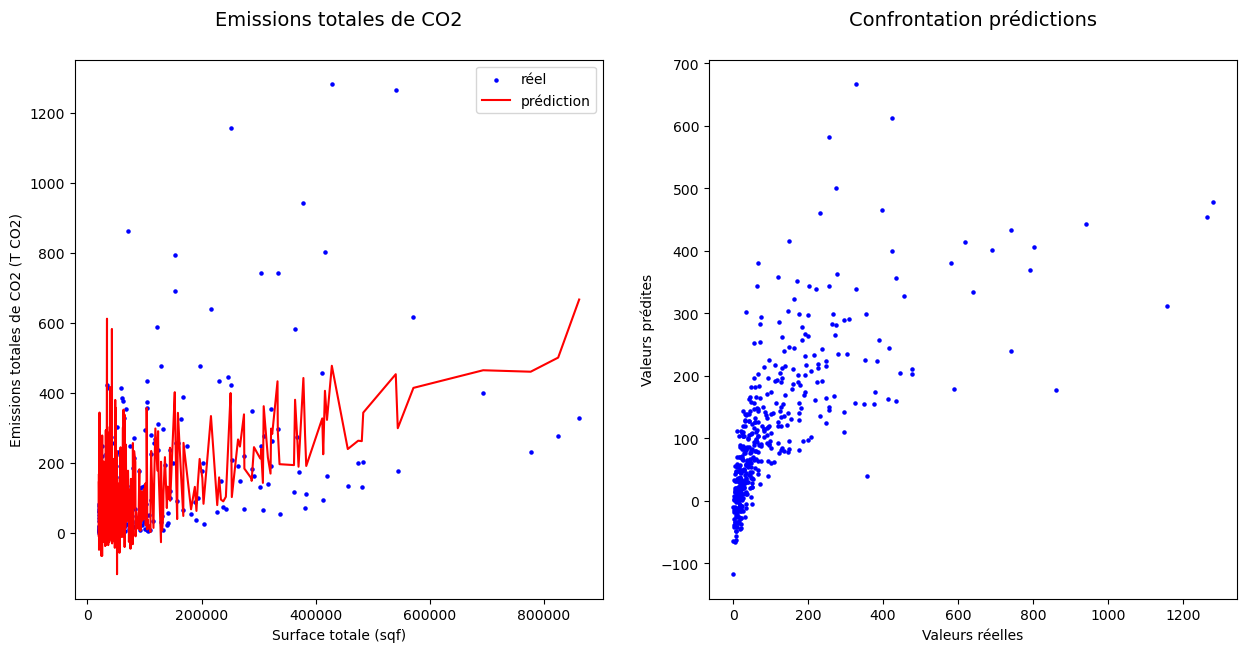

Modèle LinearRegression grid : 
meilleurs paramètres : {'linearregression__copy_X': True, 'linearregression__fit_intercept': True}
Temps d'execution : 1.26s
Score train :0.55867
Score test  :0.47098
Mse :15466.91054
Rmse:124.36603


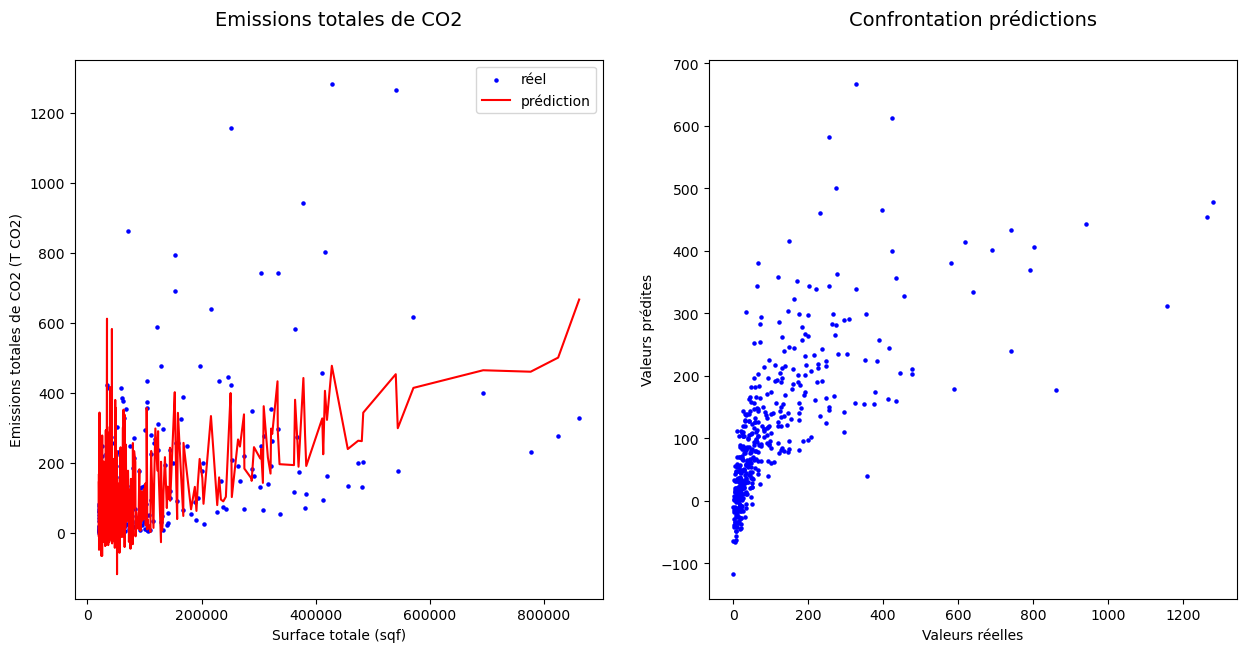

Modèle LinearRegression random :
meilleurs paramètres : {'linearregression__fit_intercept': False, 'linearregression__copy_X': True}
Temps d'execution : 0.247s
Score train :0.55864
Score test  :0.47066
Mse :15476.32731
Rmse:124.40389


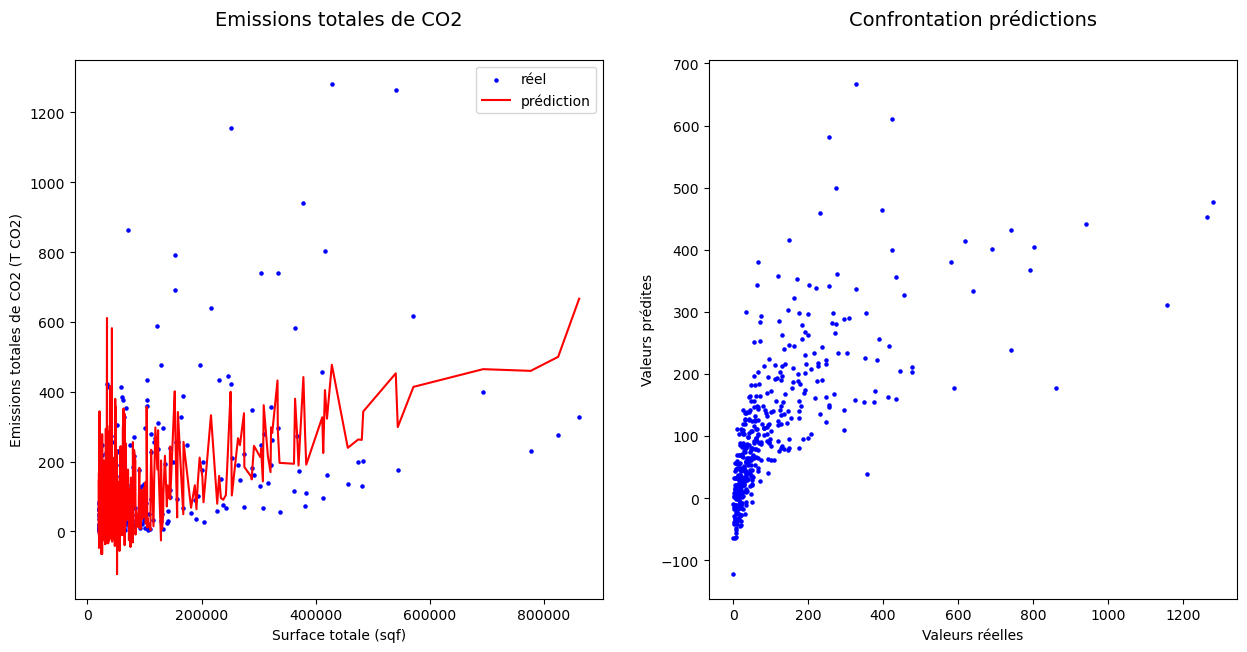

Modèle SVR base : 
Temps d'execution : 0.055s
Score train :-0.00439
Score test  :-0.01306
Mse :29618.88361
Rmse:172.10138


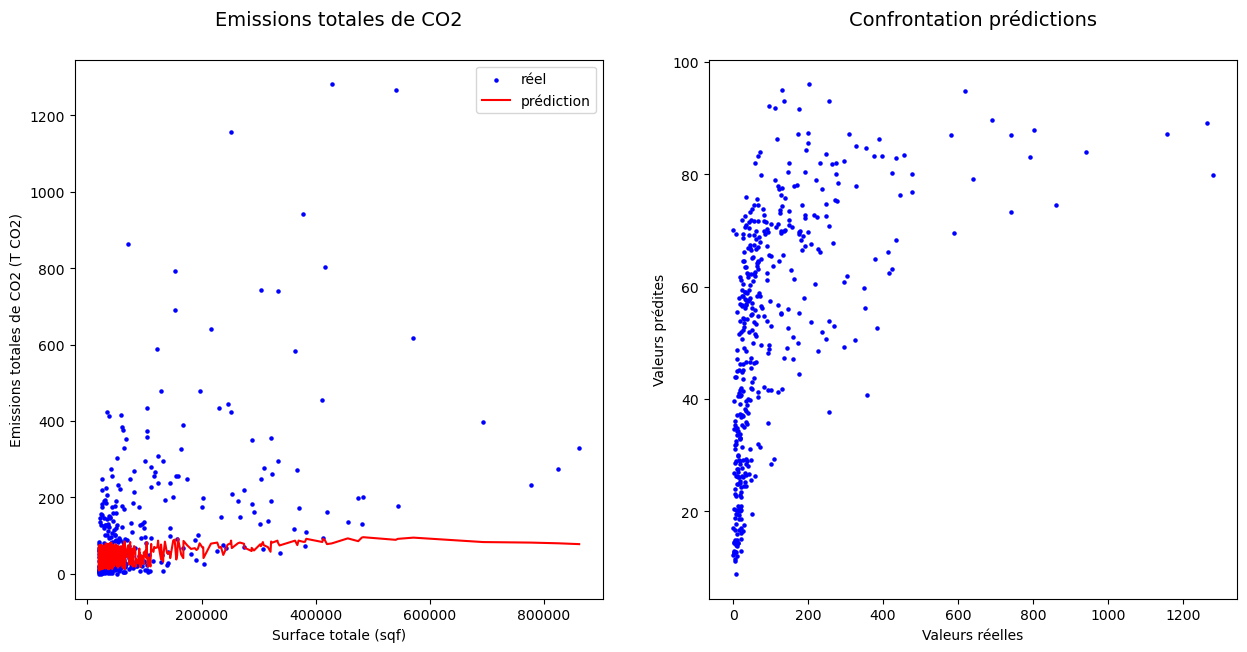

Modèle SVR grid : 
meilleurs paramètres : {'svr__C': 10, 'svr__epsilon': 0.001, 'svr__gamma': 'scale', 'svr__tol': 0.001}
Temps d'execution : 2.281s
Score train :0.24567
Score test  :0.23172
Mse :22462.27161
Rmse:149.87419


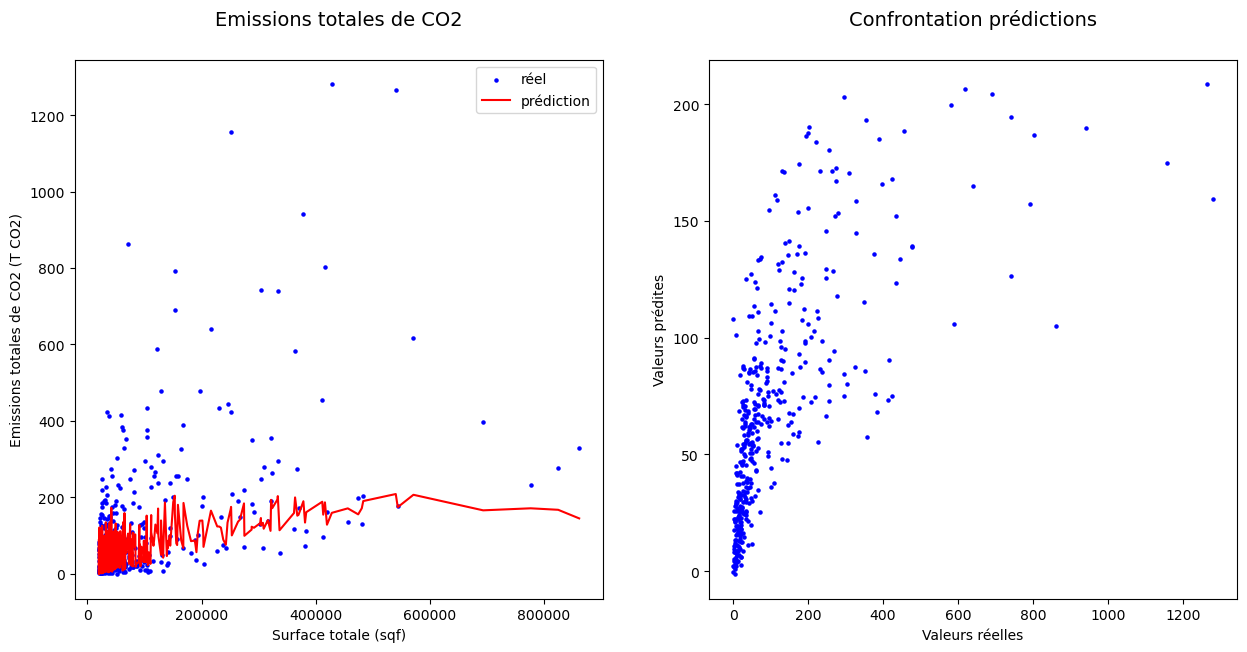

Modèle SVR random :
meilleurs paramètres : {'svr__tol': 0.001, 'svr__gamma': 'auto', 'svr__epsilon': 0.001, 'svr__C': 1}
Temps d'execution : 0.721s
Score train :-0.01295
Score test  :-0.01548
Mse :29689.48939
Rmse:172.30638


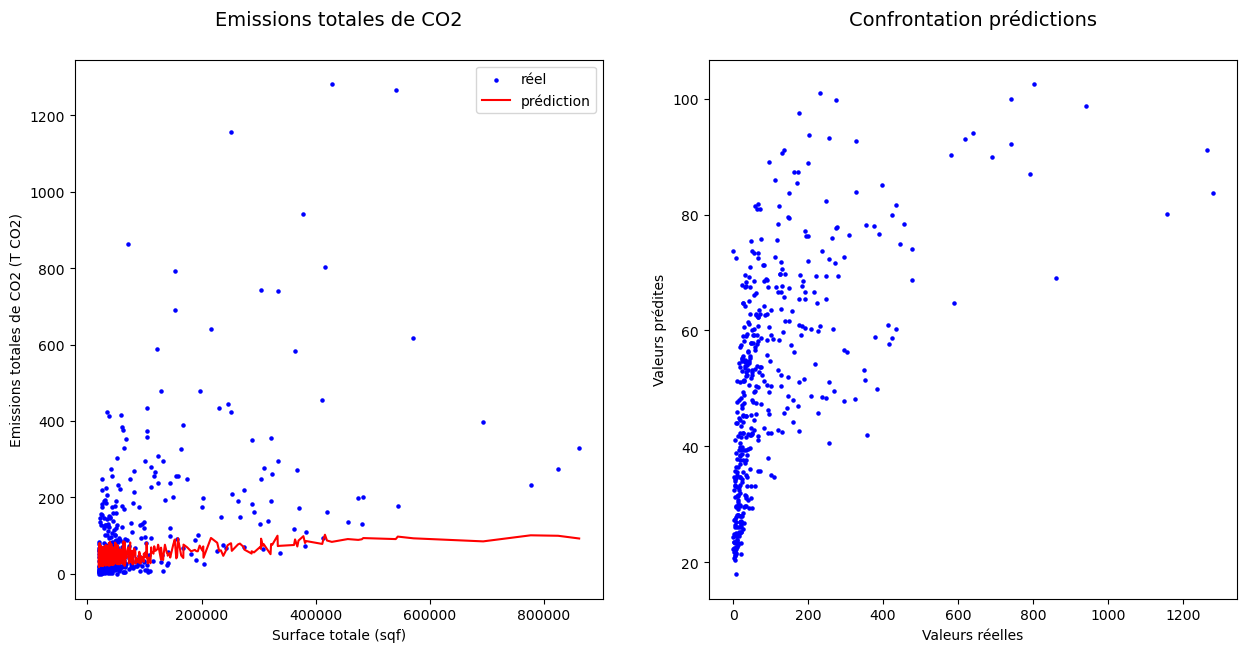

Modèle Lasso base : 
Temps d'execution : 0.021s
Score train :0.52998
Score test  :0.47686
Mse :15295.14572
Rmse:123.67354


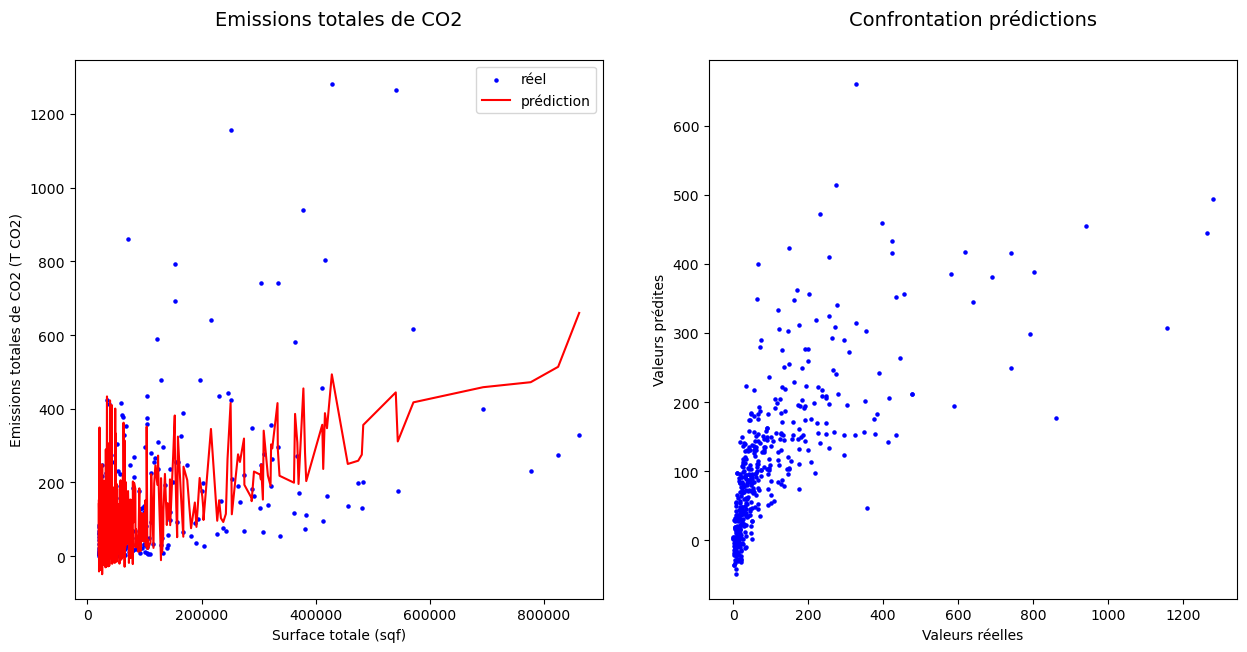

Modèle Lasso grid : 
meilleurs paramètres : {'lasso__alpha': 1, 'lasso__max_iter': 1000, 'lasso__tol': 0.001}
Temps d'execution : 0.136s
Score train :0.52995
Score test  :0.47675
Mse :15298.28332
Rmse:123.68623


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+06, tolerance: 2.384e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.929e+05, tolerance: 2.189e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+05, tolerance: 2.300e

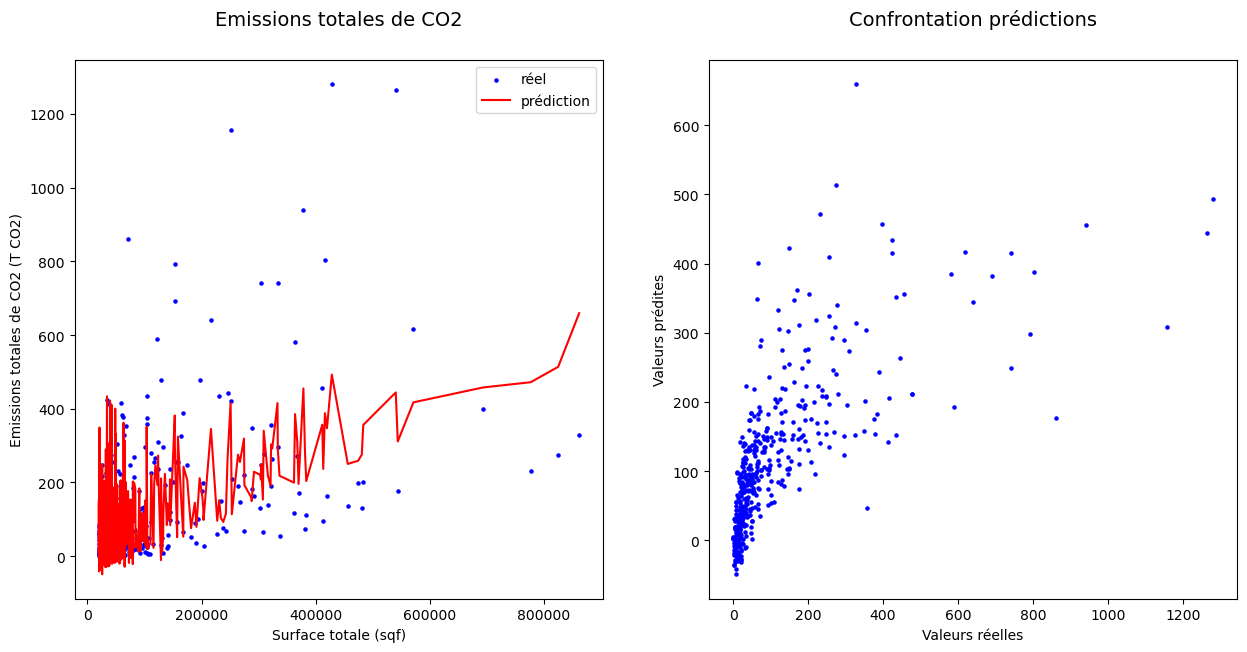

Modèle Lasso random :


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.929e+05, tolerance: 2.189e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+06, tolerance: 2.384e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+05, tolerance: 2.300e

meilleurs paramètres : {'lasso__tol': 0.001, 'lasso__max_iter': 1000, 'lasso__alpha': 1}
Temps d'execution : 0.475s
Score train :0.52995
Score test  :0.47675
Mse :15298.28332
Rmse:123.68623


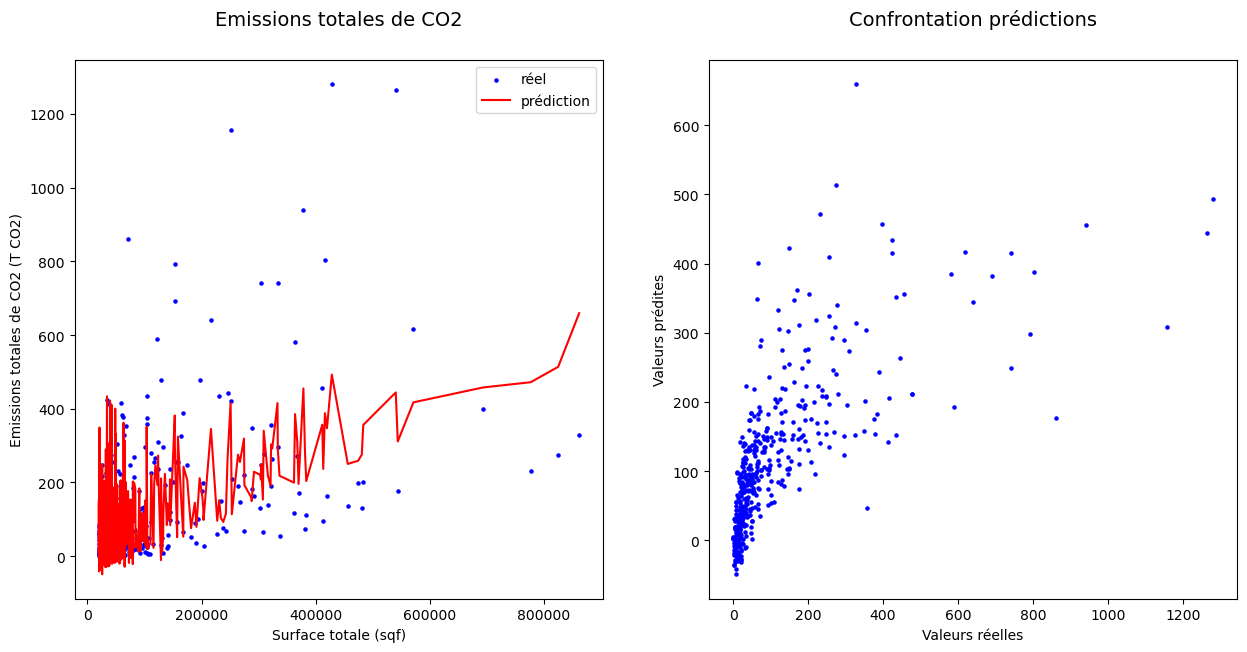

Modèle Ridge base : 
Temps d'execution : 0.025s
Score train :0.55694
Score test  :0.47705
Mse :15289.60338
Rmse:123.65114


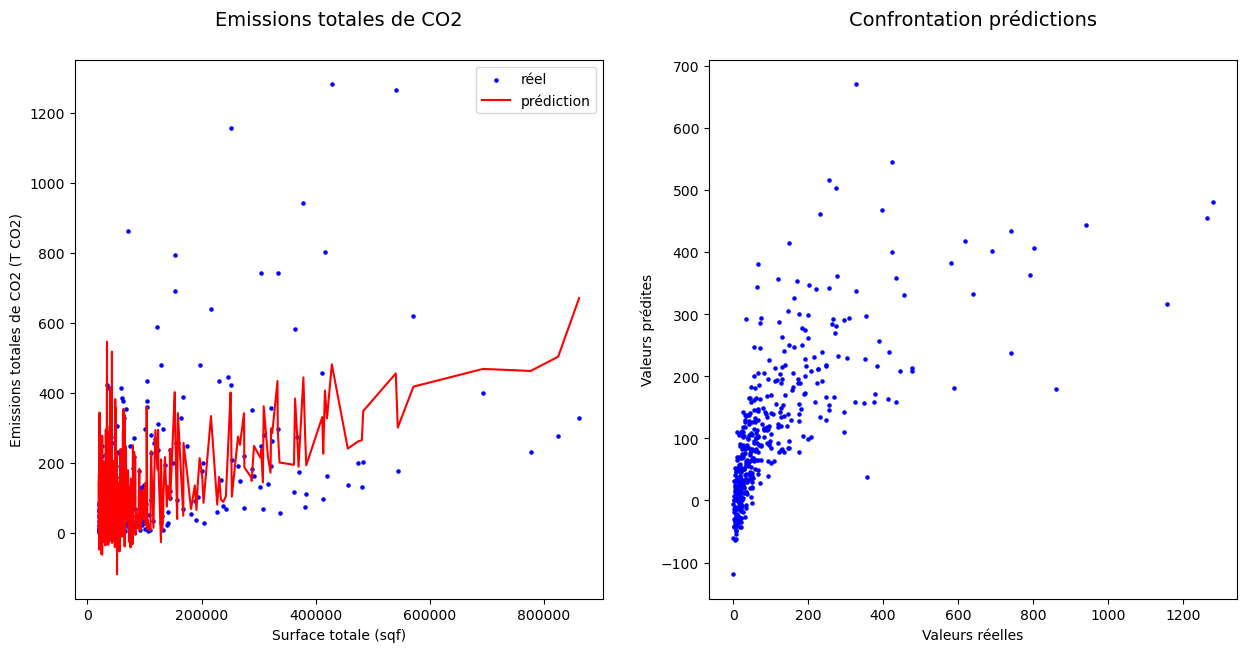

Modèle Ridge grid : 
meilleurs paramètres : {'ridge__alpha': 1, 'ridge__max_iter': 1000, 'ridge__tol': 0.001}
Temps d'execution : 0.101s
Score train :0.55694
Score test  :0.47705
Mse :15289.60338
Rmse:123.65114


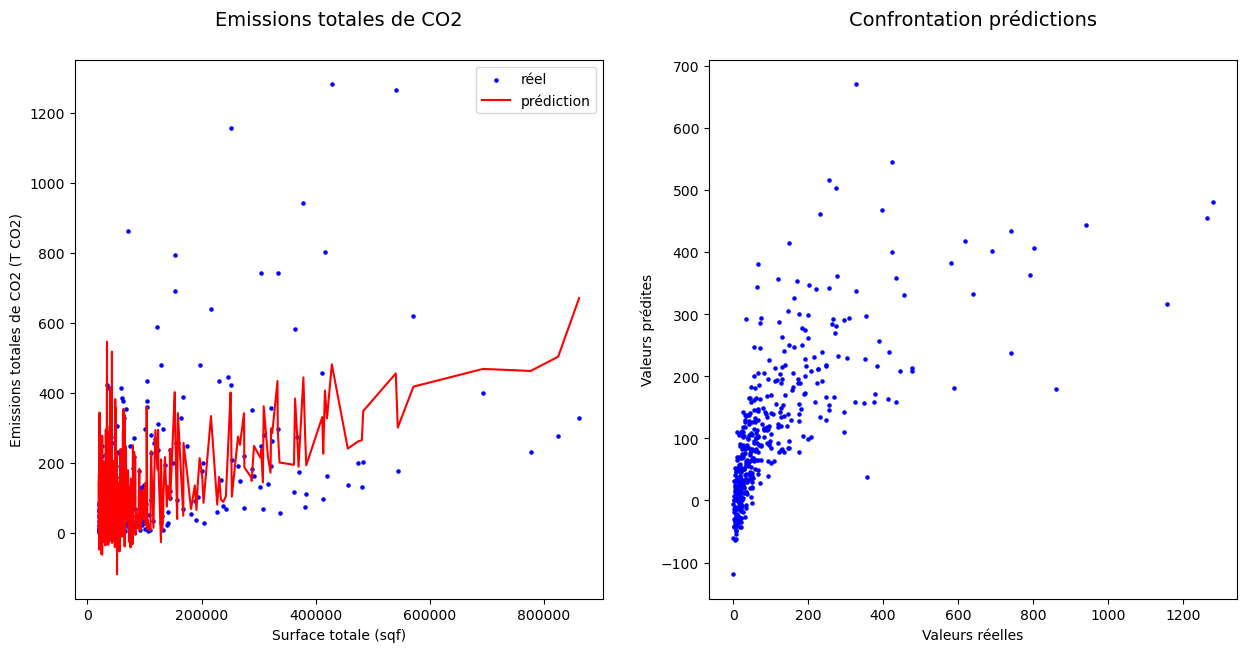

Modèle Ridge random :
meilleurs paramètres : {'ridge__tol': 0.001, 'ridge__max_iter': 1000, 'ridge__alpha': 1}
Temps d'execution : 0.305s
Score train :0.55694
Score test  :0.47705
Mse :15289.60338
Rmse:123.65114


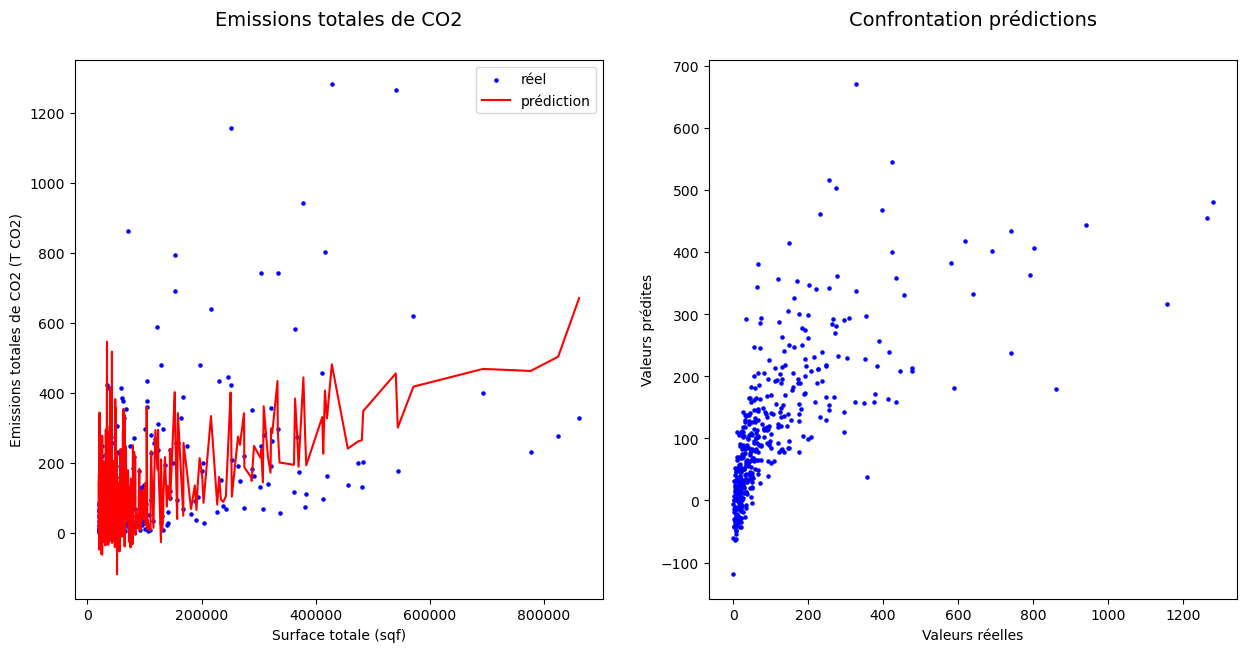

Modèle ElasticNet base : 
Temps d'execution : 0.01s
Score train :0.40013
Score test  :0.378
Mse :18185.48736
Rmse:134.85358


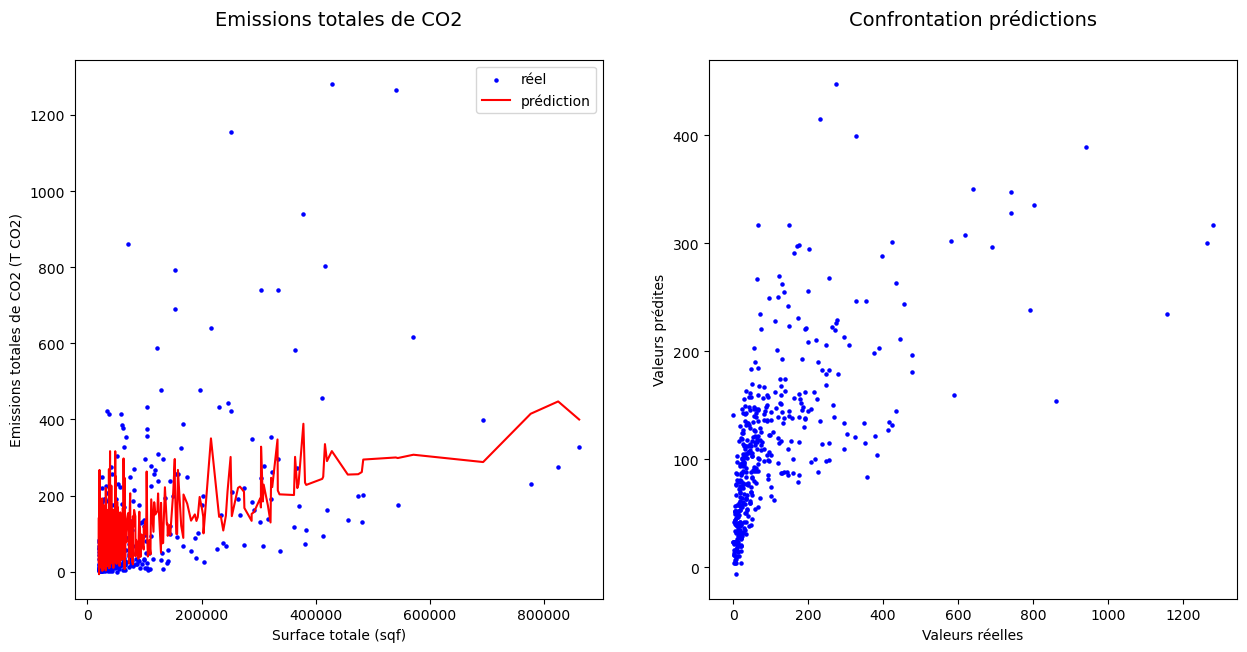

Modèle ElasticNet grid : 
meilleurs paramètres : {'elasticnet__alpha': 0.01, 'elasticnet__max_iter': 1000, 'elasticnet__tol': 0.001}
Temps d'execution : 0.157s
Score train :0.54451
Score test  :0.4836
Mse :15098.01732
Rmse:122.87399


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.497e+06, tolerance: 2.189e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.969e+06, tolerance: 2.399e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.666e+06, tolerance: 2.384e

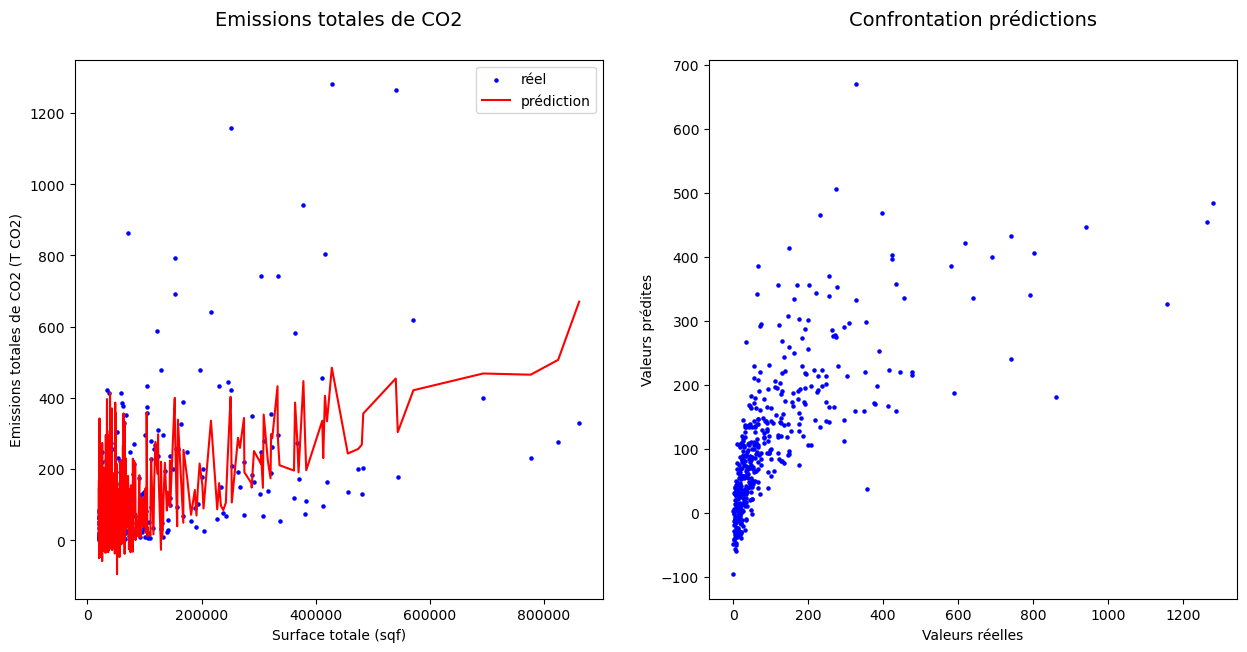

Modèle ElasticNet random :


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.497e+06, tolerance: 2.189e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.666e+06, tolerance: 2.384e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.846e+06, tolerance: 2.300e

meilleurs paramètres : {'elasticnet__tol': 0.001, 'elasticnet__max_iter': 1000, 'elasticnet__alpha': 0.01}
Temps d'execution : 0.5s
Score train :0.54451
Score test  :0.4836
Mse :15098.01732
Rmse:122.87399


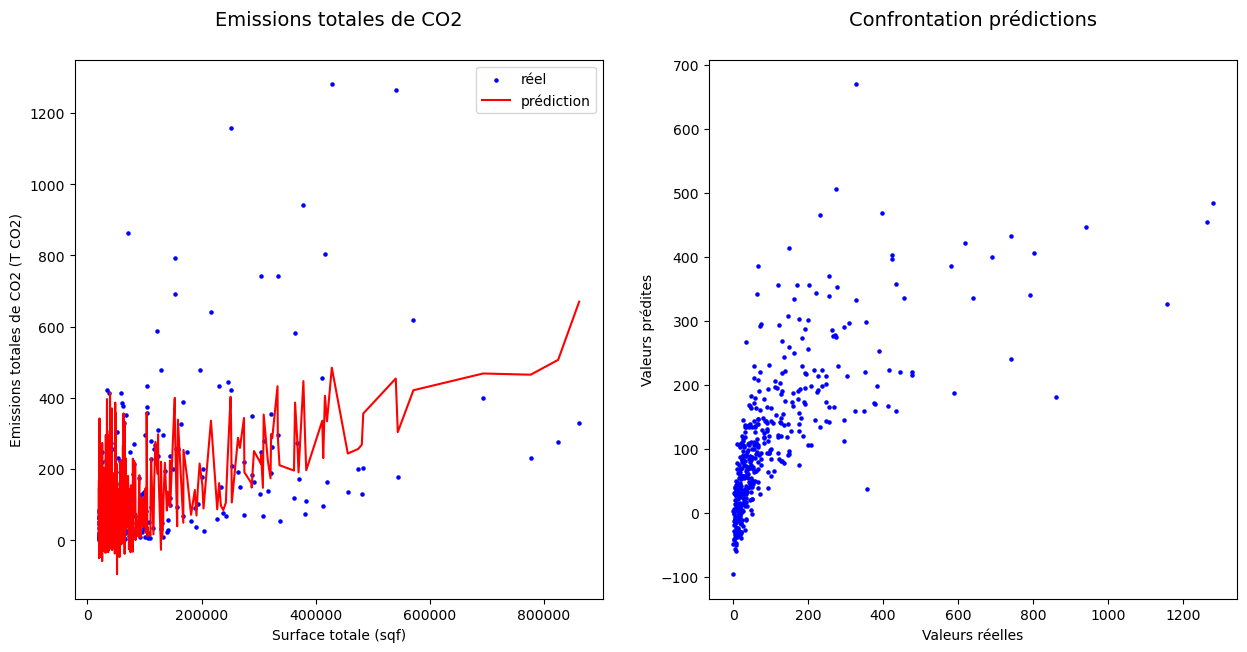

Modèle GradientBoostingRegressor base : 
Temps d'execution : 0.226s
Score train :0.87373
Score test  :0.67702
Mse :9443.09713
Rmse:97.1756


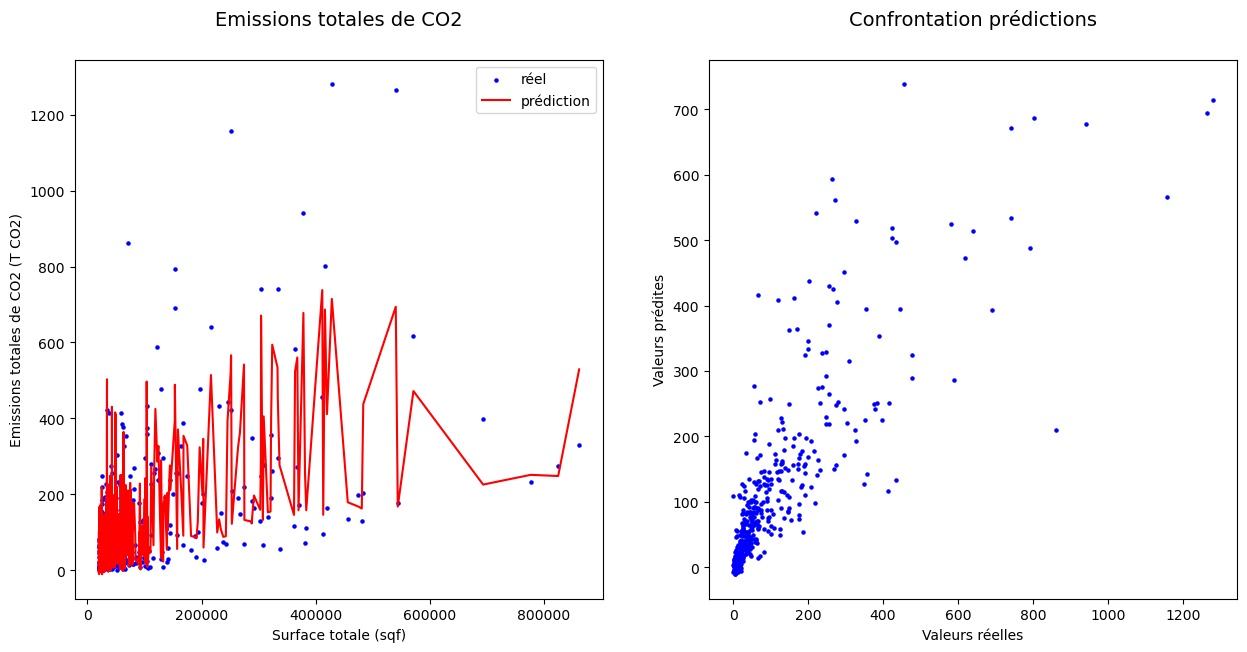

Modèle GradientBoostingRegressor grid : 
meilleurs paramètres : {'gradientboostingregressor__max_depth': None, 'gradientboostingregressor__n_estimators': 1000}
Temps d'execution : 8.128s
Score train :1.0
Score test  :0.4099
Mse :17252.85944
Rmse:131.35014


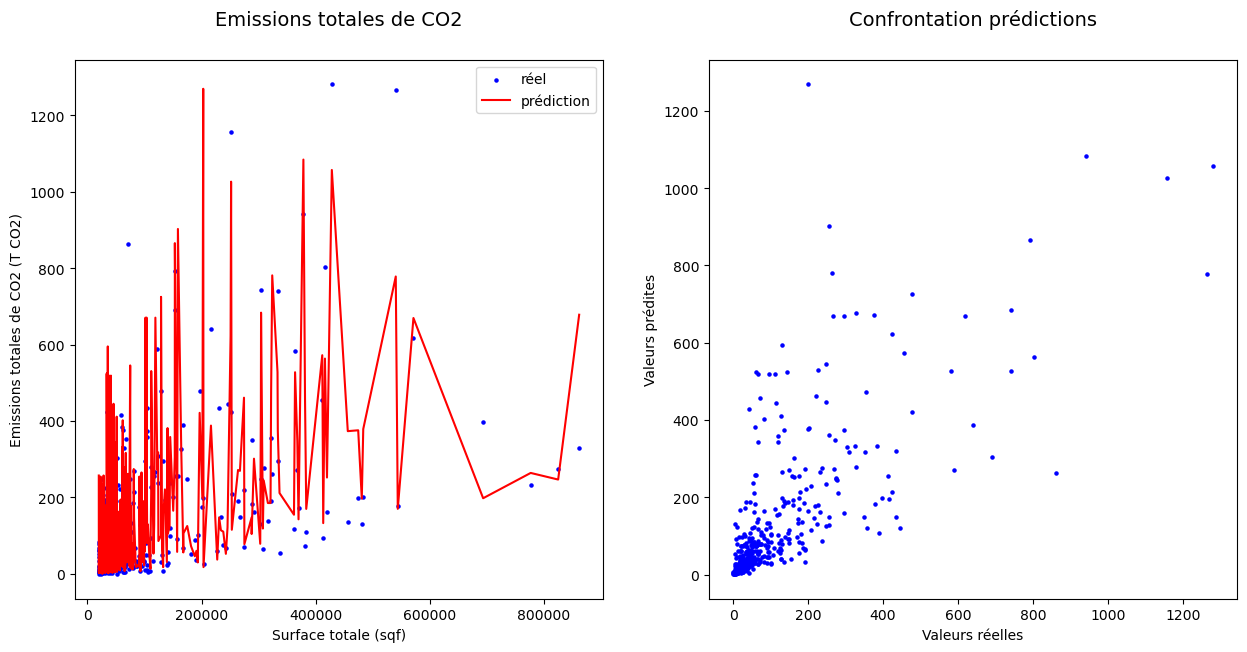

Modèle GradientBoostingRegressor random :
meilleurs paramètres : {'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__max_depth': None}
Temps d'execution : 24.806s
Score train :1.0
Score test  :0.3905
Mse :17819.81841
Rmse:133.49089


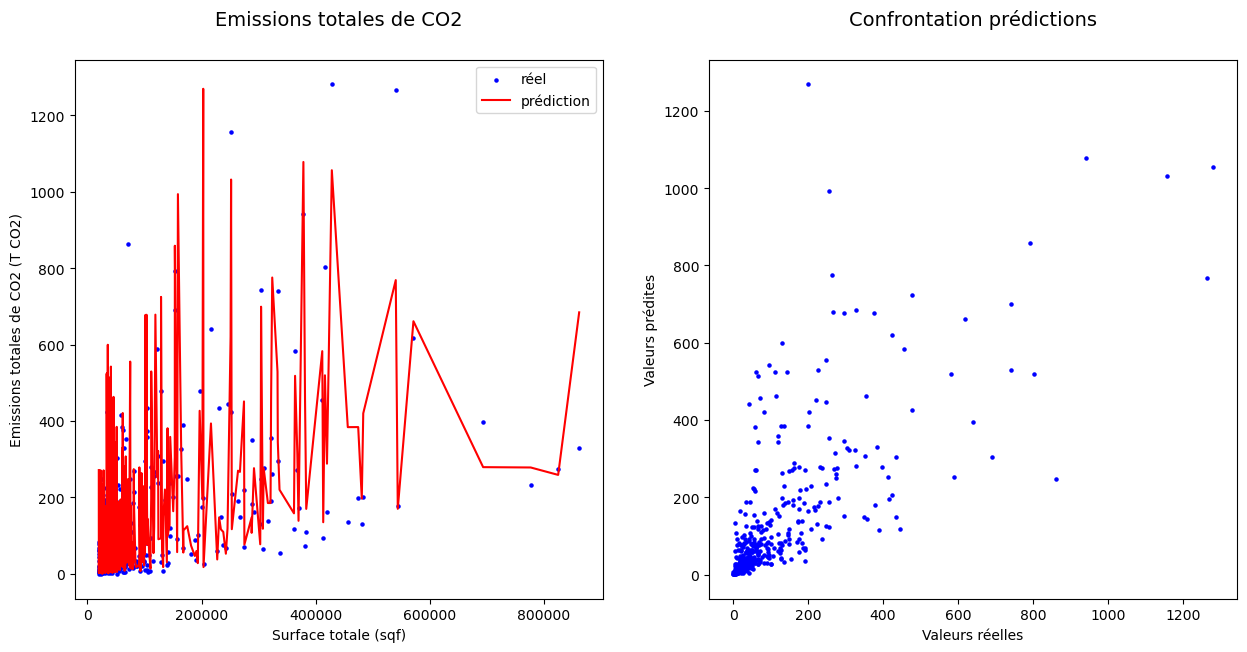

Modèle RandomForestRegressor base : 
Temps d'execution : 0.66s
Score train :0.94761
Score test  :0.65838
Mse :9988.07208
Rmse:99.94034


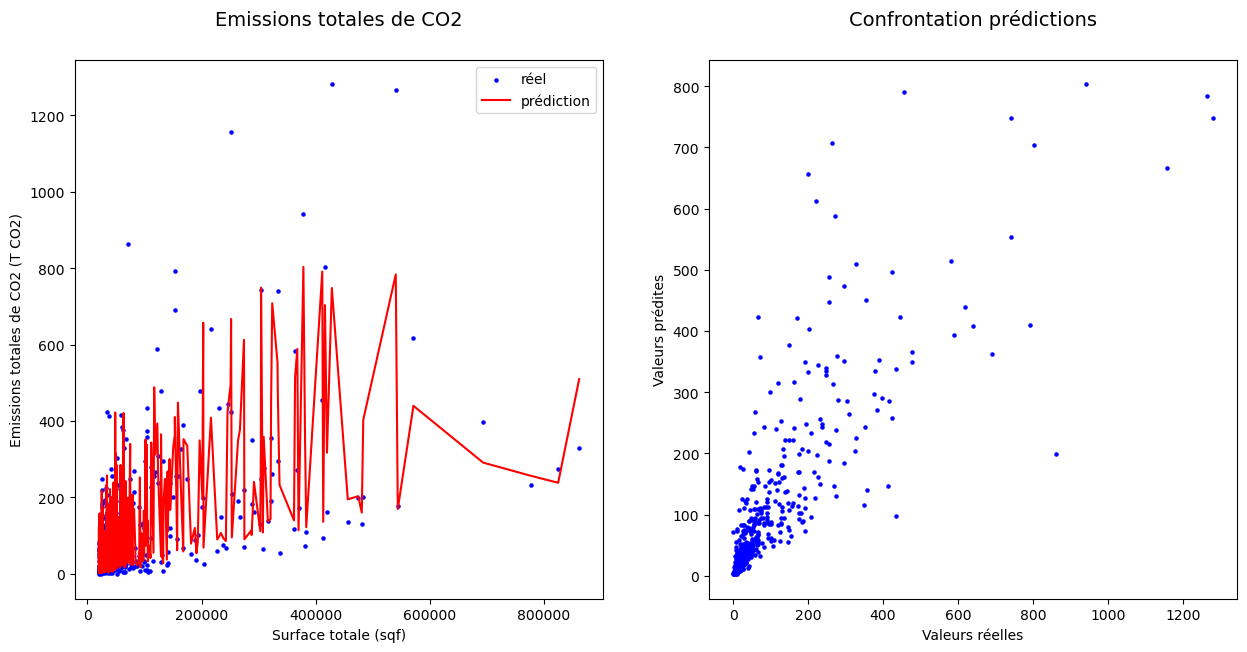

Modèle RandomForestRegressor grid : 
meilleurs paramètres : {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': None, 'randomforestregressor__n_estimators': 1000, 'randomforestregressor__n_jobs': -1}
Temps d'execution : 16.141s
Score train :0.94972
Score test  :0.66651
Mse :9750.35002
Rmse:98.74386


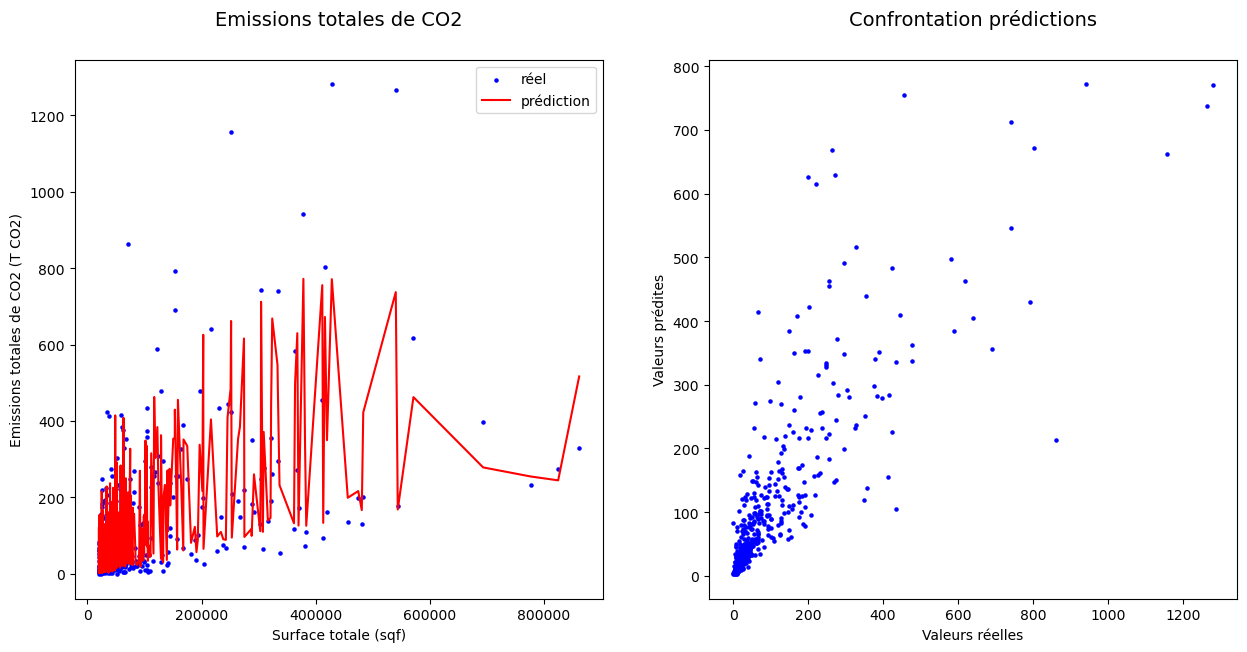

Modèle RandomForestRegressor random :
meilleurs paramètres : {'randomforestregressor__n_jobs': -1, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': None}
Temps d'execution : 15.084s
Score train :0.94965
Score test  :0.65703
Mse :10027.49033
Rmse:100.13736


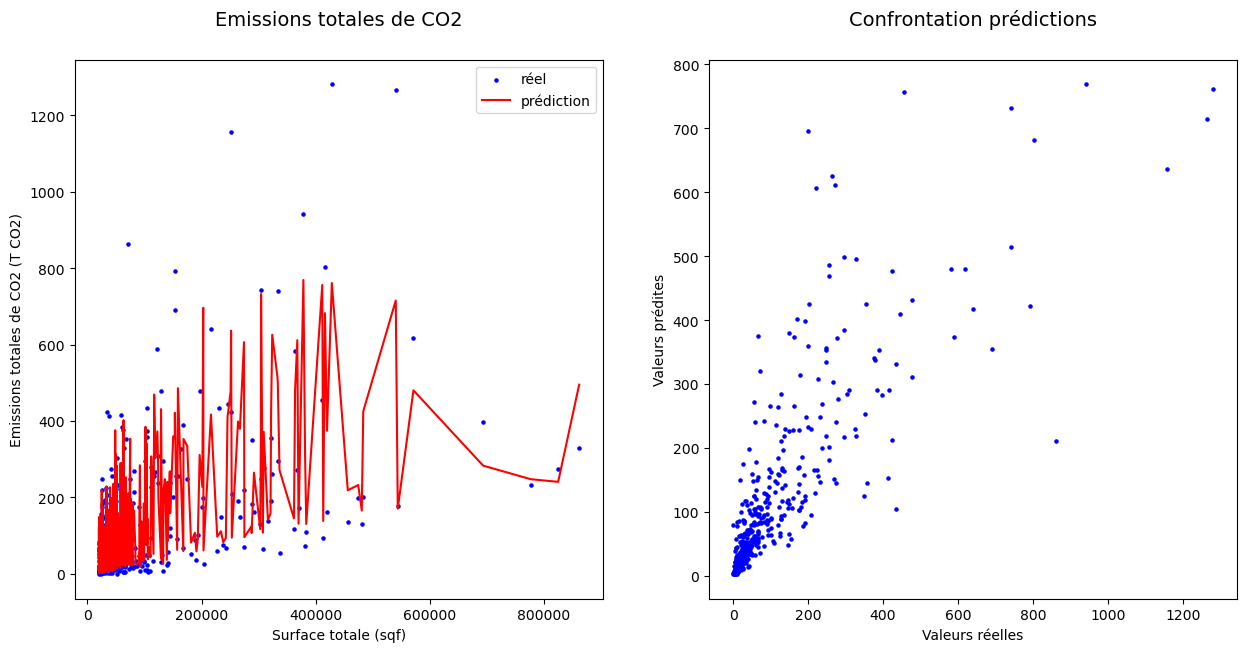

In [25]:
Result=TestModeles(dfDataInput_filtered,Modeles2Test)

### Résultats de la recherche du modèle et du tnning des Hyperparamètres

In [26]:
dfResult=pd.DataFrame(Result, columns=['Modèle', 'BaseScoreTrain', 'GridScoreTrain', 'RandScoreTrain',
                              'BaseScoreTest', 'GridScoreTest', 'RandScoreTest',
                              'BaseMse', 'GridMse', 'RandMse',
                              'BaseRmse', 'GridRmse', 'RandRmse',
                              'BaseTps', 'GridTps', 'RandTps'])
dfResult

,Modèle,BaseScoreTrain,GridScoreTrain,RandScoreTrain,BaseScoreTest,GridScoreTest,RandScoreTest,BaseMse,GridMse,RandMse,BaseRmse,GridRmse,RandRmse,BaseTps,GridTps,RandTps
0,LinearRegression,0.55867,0.55867,0.55864,0.47098,0.47098,0.47066,15466.91054,15466.91054,15476.32731,124.36603,124.36603,124.40389,0.013,1.260,0.247
1,SVR,-0.00439,0.24567,-0.01295,-0.01306,0.23172,-0.01548,29618.88361,22462.27161,29689.48939,172.10138,149.87419,172.30638,0.055,2.281,0.721
2,Lasso,0.52998,0.52995,0.52995,0.47686,0.47675,0.47675,15295.14572,15298.28332,15298.28332,123.67354,123.68623,123.68623,0.021,0.136,0.475
3,Ridge,0.55694,0.55694,0.55694,0.47705,0.47705,0.47705,15289.60338,15289.60338,15289.60338,123.65114,123.65114,123.65114,0.025,0.101,0.305
4,ElasticNet,0.40013,0.54451,0.54451,0.37800,0.48360,0.48360,18185.48736,15098.01732,15098.01732,134.85358,122.87399,122.87399,0.010,0.157,0.500
5,GradientBoostingRegressor,0.87373,1.00000,1.00000,0.67702,0.40990,0.39050,9443.09713,17252.85944,17819.81841,97.17560,131.35014,133.49089,0.226,8.128,24.806
6,RandomForestRegressor,0.94761,0.94972,0.94965,0.65838,0.66651,0.65703,9988.07208,9750.35002,10027.49033,99.94034,98.74386,100.13736,0.660,16.141,15.084


## Modèle RandomForest optimisé 

X_train de forme (1012, 29) et y_train de forme (1012,)
X_test de forme (434, 29) et y_test de forme (434,)

Score train:0.94951
Score test:0.65475
R2  :0.65475
Mse :10093.98877
Rmse:100.46884
Temps d'apprentissage :1.347s


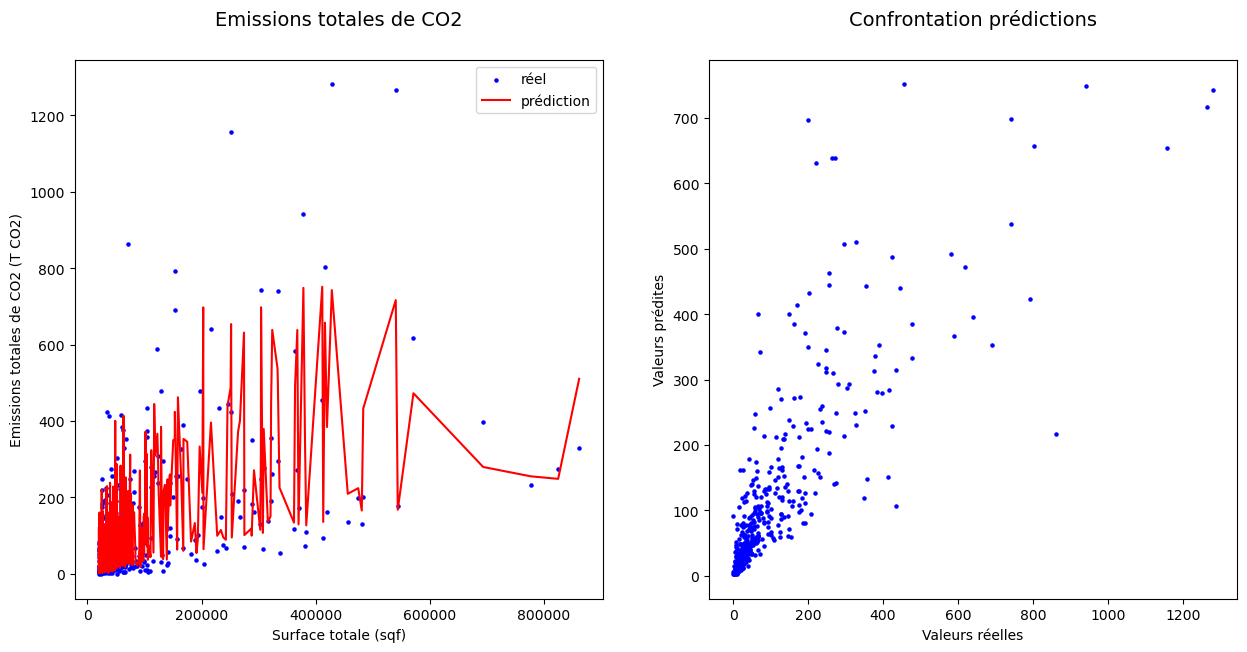

In [27]:
y = dfDataInput_filtered[Cible[1]]
X = dfDataInput_filtered.drop(Cible[1], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles)).set_output(transform="pandas")

model=make_pipeline(preprocessor, RandomForestRegressor(random_state=66, n_jobs=-1, n_estimators=500, max_features=None, max_depth=None))
depart = time.time()
model.fit(X_train, y_train)
temps = round(time.time() - depart,3)
y_pred=model.predict(X_test)

scores(model,X_train,X_test,y_train,y_test,y_pred)
print(f"Temps d'apprentissage :{temps}s")
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')


## Analyse de l'importance des données

### Visualisation des principaux arbres avec Graphviz

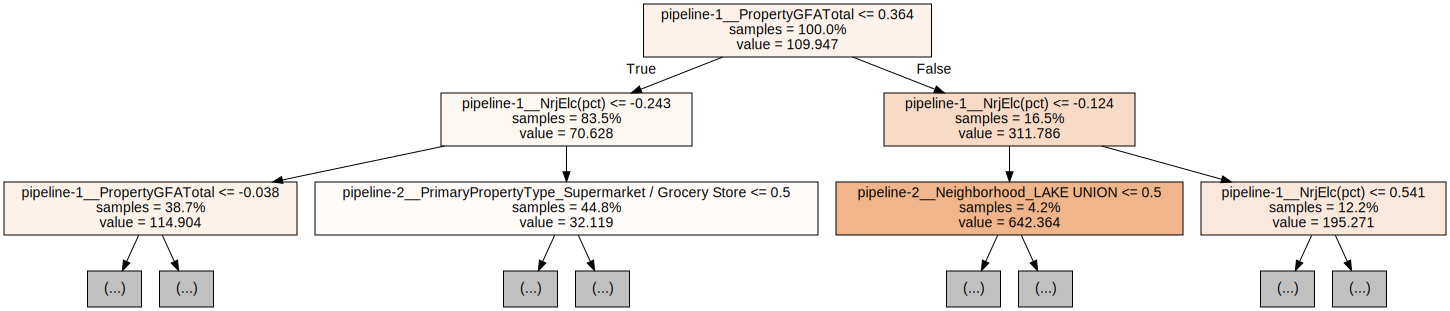

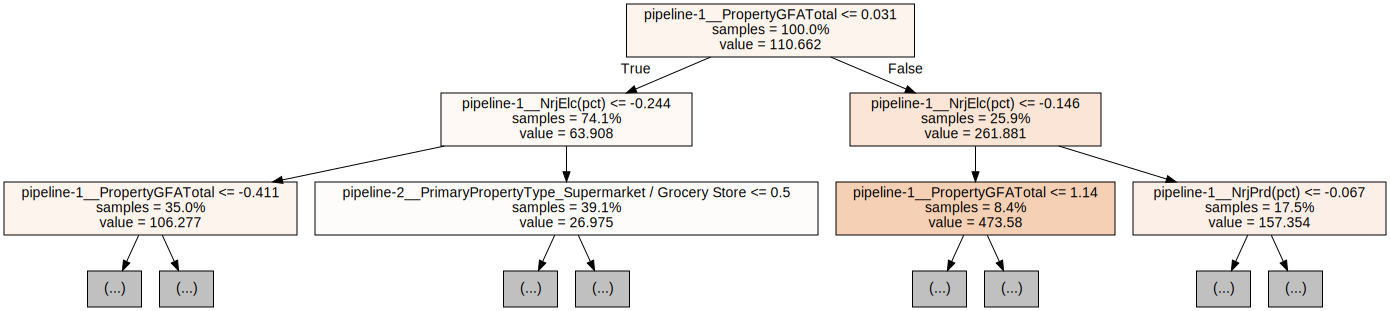

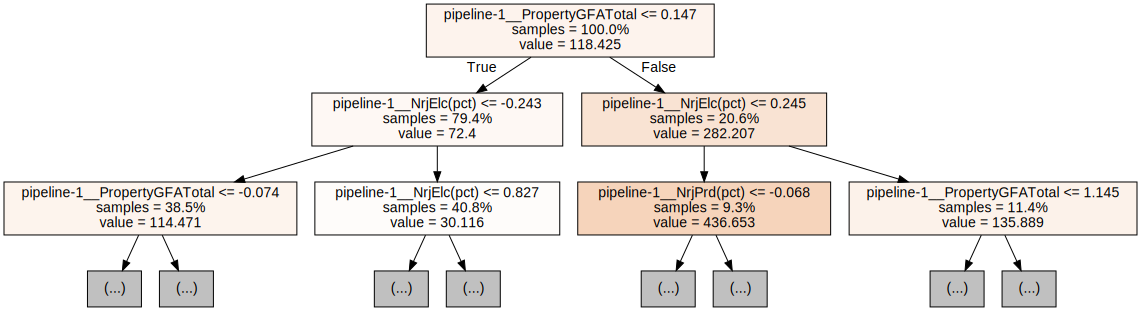

In [28]:
## ce module nécéssite l'installation du package graphviz
## avec la commande: apt-get install graphviz
## puis d'installer le module à l'aide de pip install
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
for i in range(3):
    tree = model.steps[1][1].estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=preprocessor.fit_transform(X_train).columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

### Diminution moyenne de l'impureté (MDI)

Visualisation de l\importance des variables sous forme numérique :
PropertyGFATotal                                   3.498733e-01
NrjElc(pct)                                        2.465654e-01
NumberofFloors                                     1.255644e-01
ENERGYSTARScore                                    7.453180e-02
NrjGaz(pct)                                        3.334060e-02
PrimaryPropertyType_Supermarket / Grocery Store    3.278697e-02
Longitude                                          3.128497e-02
Latitude                                           1.867533e-02
NrjPrd(pct)                                        1.673495e-02
AgeBuilding                                        1.472172e-02
NrjVap(pct)                                        9.992571e-03
PrimaryPropertyType_Other                          7.410624e-03
Prct_Parking                                       5.705859e-03
PrimaryPropertyType_Senior Care Community          4.808737e-03
PrimaryPropertyType_Hotel            

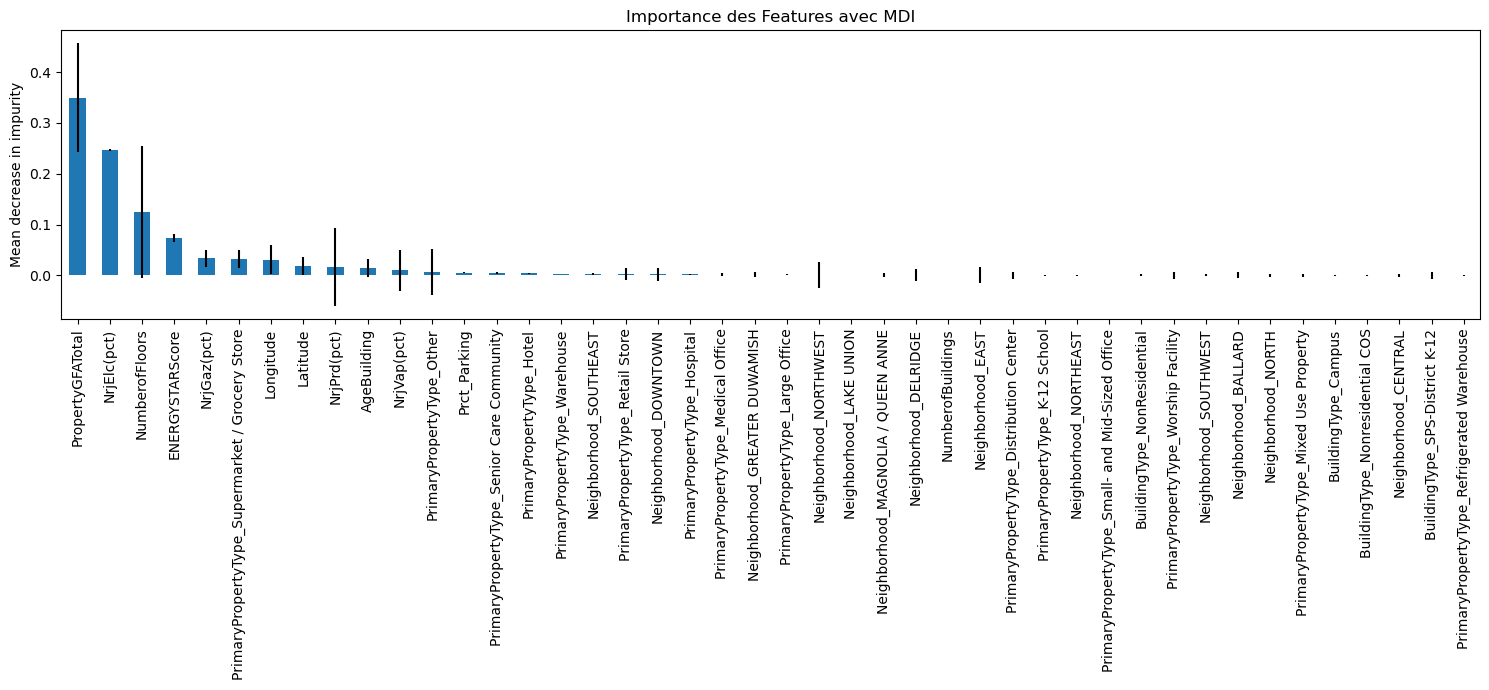

In [48]:
ImportanceFeaturesMDI(model.steps[1][1],Affnum=1)

### Calcul de l'importance des variables avec SHAP

In [30]:
check_additivity = False

X_train_shap = preprocessor.fit_transform(X_train)
X_test_shap = preprocessor.fit_transform(X_test)
model_shap = model.steps[1][1]

feature_names=X_train_shap.columns
changeChars=[('pipeline-1__',''),('pipeline-2__',''),('(','_'),(')','')]
for rech, trgt in changeChars:
    feature_names = [name.replace(rech,trgt) for name in feature_names]

explainer = shap.TreeExplainer(model_shap, feature_names=feature_names)
single_shap_value = explainer(X_test_shap.sample(n=1), check_additivity=check_additivity)
shap_values = explainer(X_test_shap, check_additivity=check_additivity)
shap_values.feature_names=feature_names

#### Impact moyen des variables sur la sortie

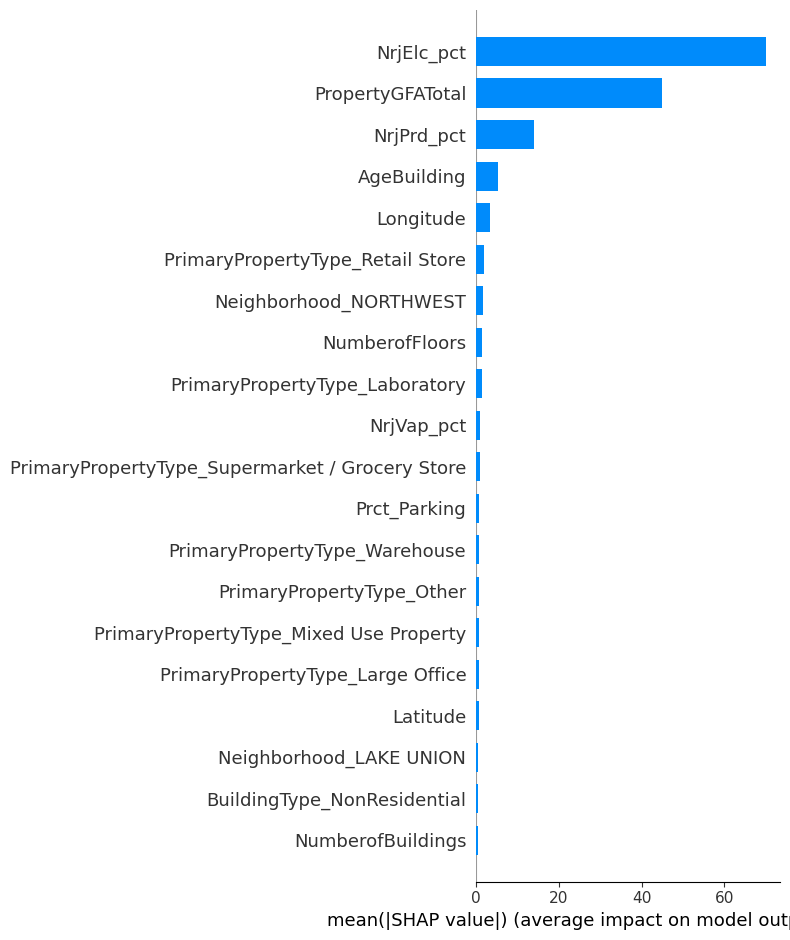

In [31]:
shap.summary_plot(single_shap_value, feature_names=feature_names, plot_type='bar')

#### Impact moyen des variables sur la sortie

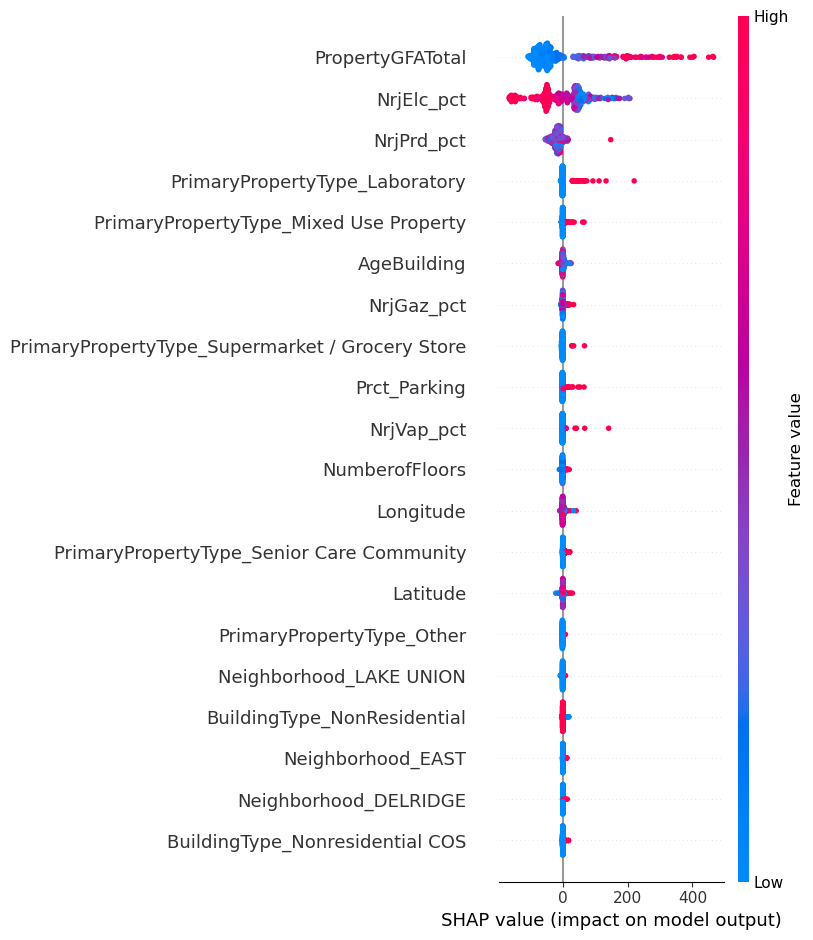

In [32]:
shap.summary_plot(shap_values, feature_names=feature_names)

#### Waterfall sur l'importance des variables

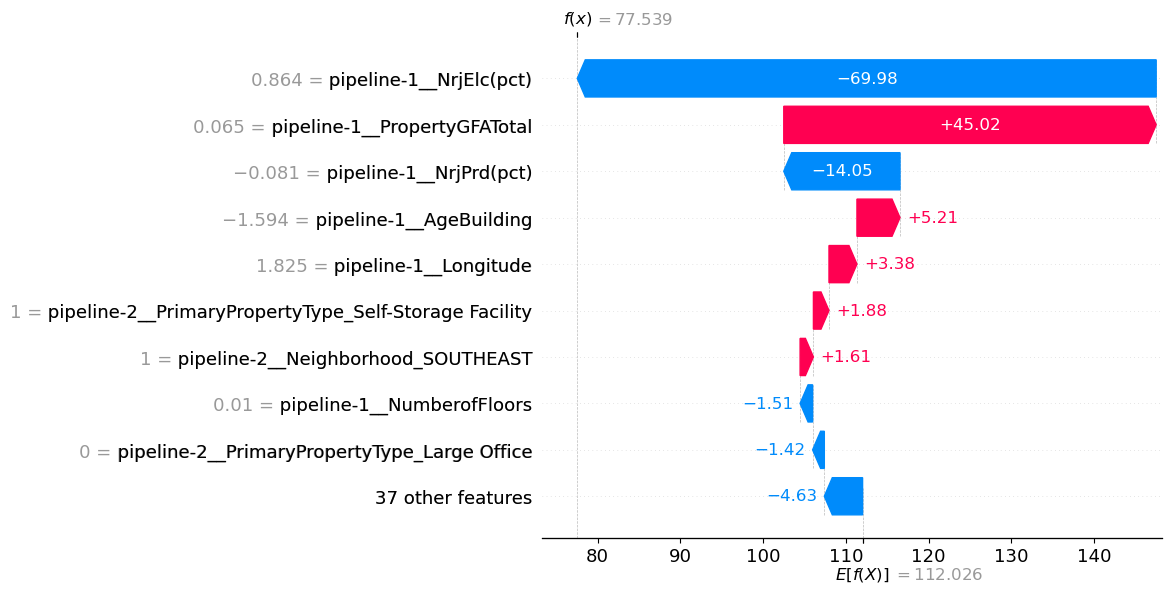

In [33]:
shap.plots.waterfall(single_shap_value[0], max_display=10)

#### Heatmap sur l'importance des variables

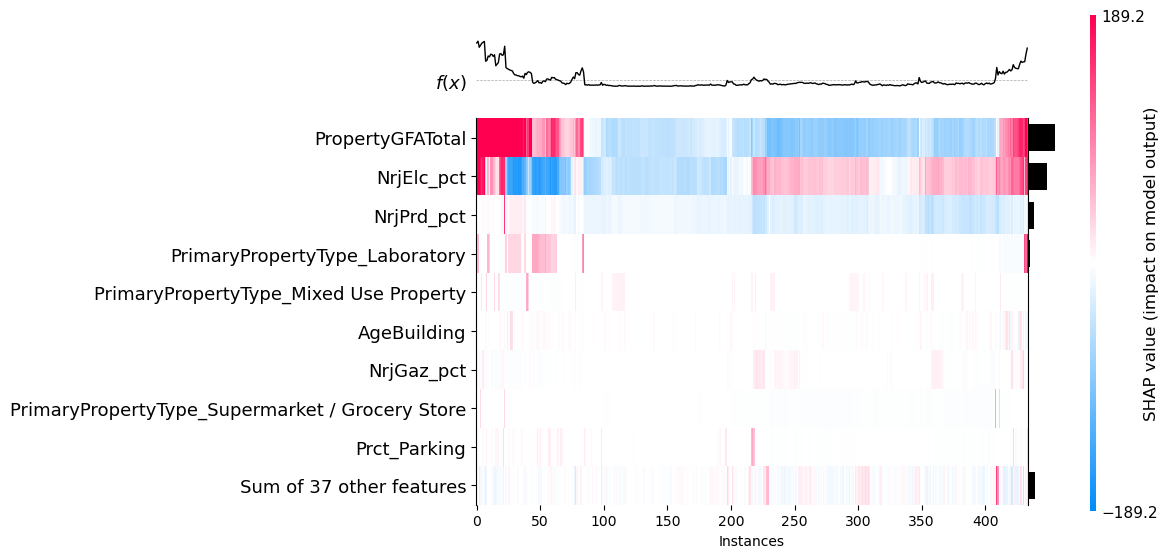

<Axes: xlabel='Instances'>

In [34]:
shap.plots.heatmap(shap_values)

## Analyse de l'importance de l'energy star score

### selection des données

In [35]:
dfDataNrjScore=dfDataInput_filtered.loc[~dfDataInput_filtered['ENERGYSTARScore'].isna()].copy()
y = dfDataNrjScore[Cible[1]]
X = dfDataNrjScore.drop(Cible[1], axis=1)
ResultES=[]

### Modèlisation RandomForest sans EnergyStar (réference)

Temps d'execution : 0s
Score train :0.95794
Score test  :0.68173
Mse :5606.17892
Rmse:74.87442


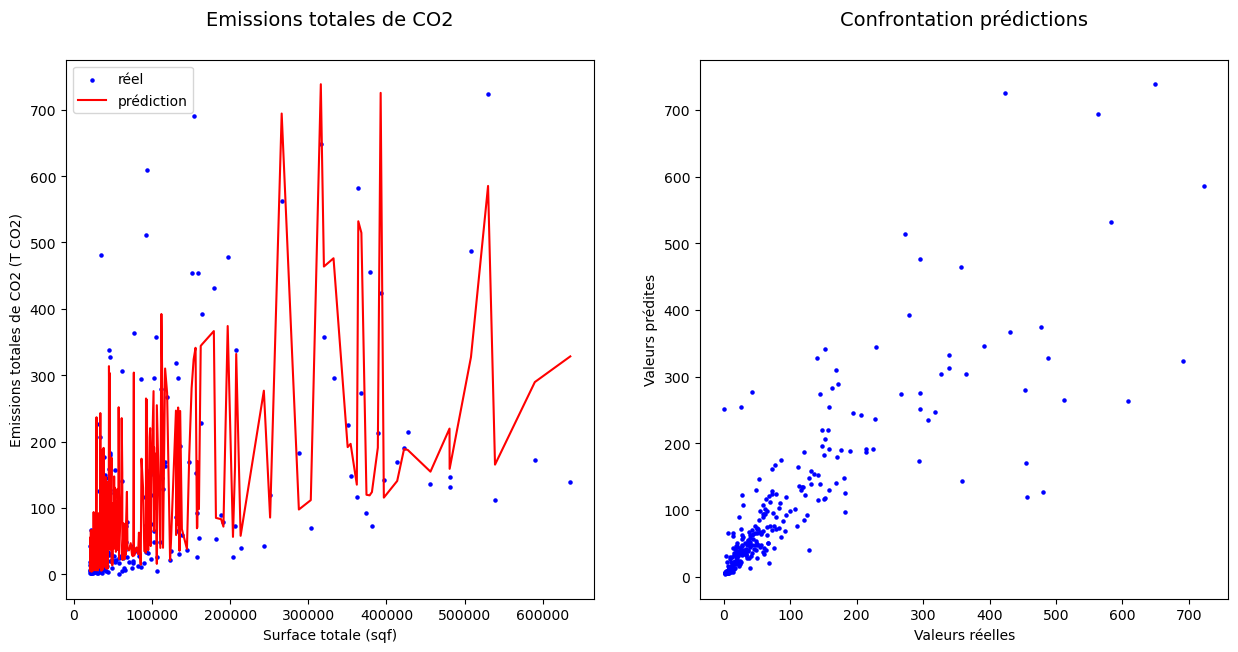

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles)).set_output(transform="pandas")

model=make_pipeline(preprocessor, RandomForestRegressor(random_state=66, n_jobs=-1, n_estimators=1000, max_features=None, max_depth=None))
#print(model)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

ScoreSansEs=scores2(model,X_train,X_test,y_train,y_test,y_pred,0)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')
ResultES.append(['Sans EnergyStarScore',ScoreSansEs[0],ScoreSansEs[1],ScoreSansEs[2],ScoreSansEs[3]])

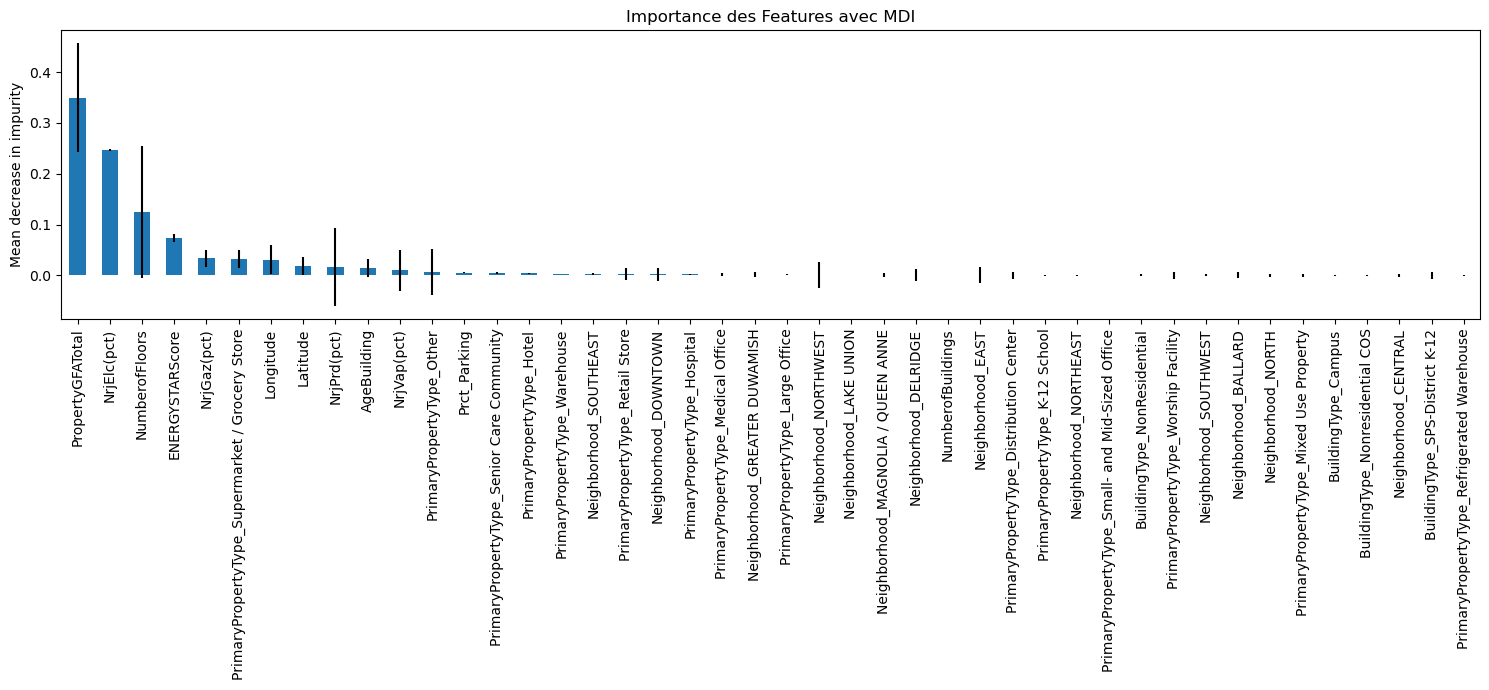

In [49]:
ImportanceFeaturesMDI(model.steps[1][1])

### Modèlisation RandomForest avec EnergyStar

Temps d'execution : 0s
Score train :0.96363
Score test  :0.7379
Mse :4616.66484
Rmse:67.94604


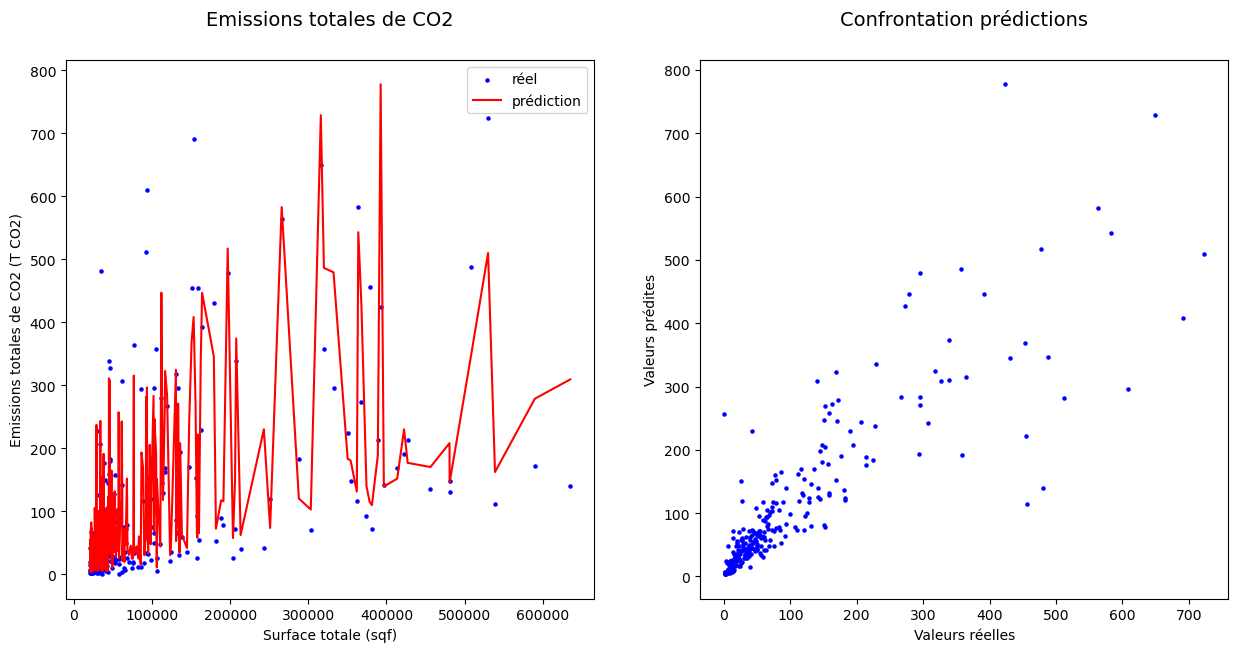

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=Id_Random) 

features_numeriques=['PropertyGFATotal', 'NumberofBuildings', 'NumberofFloors', 'Prct_Parking',
                     'AgeBuilding','Latitude','Longitude','NrjPrd(pct)', 'NrjElc(pct)',
                     'NrjVap(pct)', 'NrjGaz(pct)','ENERGYSTARScore']
features_categorielles=['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

pipe_numerique=make_pipeline(SimpleImputer(), StandardScaler())
pipe_categoriel=make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
preprocessor=make_column_transformer((pipe_numerique, features_numeriques),
                                     (pipe_categoriel, features_categorielles)).set_output(transform="pandas")

model=make_pipeline(preprocessor, RandomForestRegressor(random_state=66, n_jobs=-1, n_estimators=1000, max_features=None, max_depth=None))
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

ScoreAvecEs=scores2(model,X_train,X_test,y_train,y_test,y_pred,0)
graphResult(X_test['PropertyGFATotal'],y_test,y_pred,'Surface totale (sqf)')
ResultES.append(['Avec EnergyStarScore',ScoreAvecEs[0],ScoreAvecEs[1],ScoreAvecEs[2],ScoreAvecEs[3]])

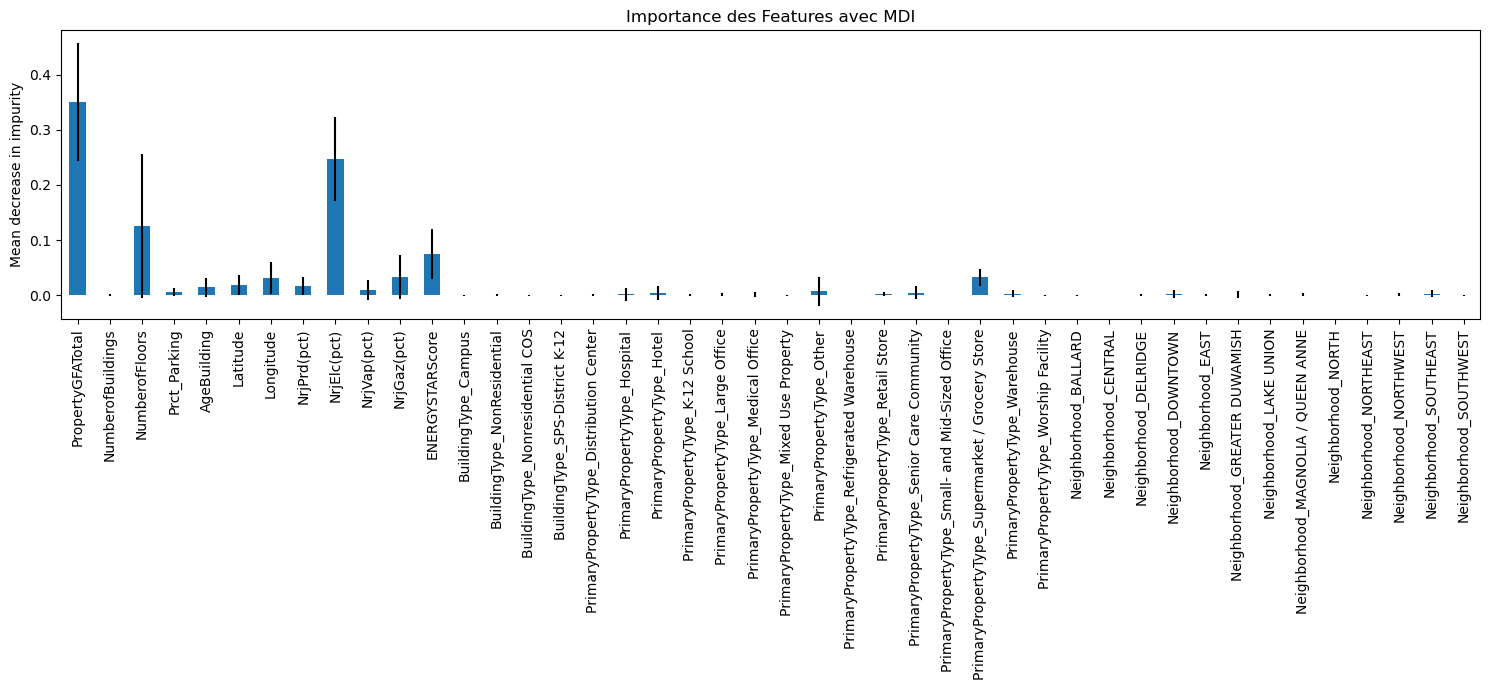

In [39]:
ImportanceFeaturesMDI(model.steps[1][1])

In [40]:
dfResultES=pd.DataFrame(ResultES, columns=['Modèle émission CO2', 'ScoreTrain', 'ScoreTest', 'Mse', 'Rmse'])
dfResultES

,Modèle émission CO2,ScoreTrain,ScoreTest,Mse,Rmse
0,Sans EnergyStarScore,0.95794,0.68173,5606.17892,74.87442
1,Avec EnergyStarScore,0.96363,0.73790,4616.66484,67.94604
